In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

from glob import glob
import functools
import json
import re

sns.set_theme(style="darkgrid", context="notebook", palette=sns.color_palette("rocket", 4))
matplotlib.rcParams['figure.figsize'] = (20, 10)

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

from glob import glob
import functools
import json
import re

# pick a nice theme :)
sns.set_theme(style="darkgrid", context="notebook", palette=sns.color_palette("rocket", 4))
matplotlib.rcParams['figure.figsize'] = (20, 10)

%matplotlib inline

In [3]:
# load all results
results_files = sorted(glob(f"results/*.json"))
all_results = []
# store layers for each model here
layers = {}
for file in results_files:
    # read json
    with open(file, "r") as f:
        results = json.load(f)
    # extract the model name from the filename
    model = re.search(r"results/(.*?).json", file).group(1)
    # save layers without breaking df
    layers[model] = results.pop("layers")
    for task_name, problem in results.items():
        # add the data to the results (to be turned into df)
        all_results.append({
            "task": task_name,
            "model": model,
            "model/task": f"{model}/{task_name}"}
            |
            {
                # keep attributes as arrays
                problem_name: np.array(values)
                for problem_name, values in problem.items()
            }
        )
# there is no model called "gptr2-nano" so save layers separately
layers["gptr2-nano"] = layers["gptr2-nano-without-momentum-without-weight-decay"]
df = pd.DataFrame(all_results)
df.head()

,task,model,model/task,outliers,kurtosis,rotated-kurtosis,rms,accuracy,reversed-accuracy,top1,top5,reversed-top1,reversed-top5
0,mnli,gpt2-base-finetuned,gpt2-base-finetuned/mnli,"[0.0, 0.036458333333333336, 0.0546875, 0.09505...","[11.530987739562988, 74.23395538330078, 90.541...","[2.895934820175171, 2.9088809490203857, 2.9863...","[0.17225034534931183, 2.0643858909606934, 3.02...","[0.31818644931227713, 0.3193071828833418, 0.30...","[0.3182, 0.332, 0.3345, 0.318, 0.3185, 0.3293,...",NaN,NaN,NaN,NaN
1,mnli-mm,gpt2-base-finetuned,gpt2-base-finetuned/mnli-mm,"[0.0, 0.03515625, 0.048177083333333336, 0.0924...","[11.628100395202637, 72.98341369628906, 90.120...","[2.9982657432556152, 2.9242610931396484, 3.059...","[0.17218723893165588, 2.0651378631591797, 3.03...","[0.31946704637917006, 0.3197721724979658, 0.30...","[0.3182, 0.3305, 0.3348, 0.319, 0.318, 0.3257,...",NaN,NaN,NaN,NaN
2,mnli,gpt2-base,gpt2-base/mnli,"[0.0, 0.0234375, 0.028645833333333332, 0.04296...","[11.536112785339355, 83.33000183105469, 87.768...","[2.896453619003296, 2.8998031616210938, 2.9980...","[0.17212806642055511, 2.004455089569092, 3.035...",NaN,NaN,NaN,NaN,NaN,NaN
3,mnli-mm,gpt2-base,gpt2-base/mnli-mm,"[0.0, 0.01953125, 0.029947916666666668, 0.0403...","[11.63365650177002, 82.12107849121094, 87.6034...","[2.9980878829956055, 2.9028360843658447, 3.086...","[0.17206445336341858, 2.003962993621826, 3.038...",NaN,NaN,NaN,NaN,NaN,NaN
4,mnli,gpt2-large-finetuned,gpt2-large-finetuned/mnli,"[0.0, 0.240234375, 0.4150390625, 0.5048828125,...","[9.249516487121582, 162.57684326171875, 152.33...","[3.1099064350128174, 3.063145637512207, 2.8290...","[0.0907880961894989, 4.053773880004883, 4.9769...","[0.33428425878757007, 0.35496688741721855, 0.3...","[0.3226, 0.3451, 0.3272, 0.3268, 0.3262, 0.327...",NaN,NaN,NaN,NaN


In [4]:
# calculate percentage of outliers
df["percent"] = df["outliers"] * 100

In [5]:
# split up df into different groups
resnet_df = df[df["model"].str.match(r"resnet\d+$")]
# resort the resnet df (was alphabetical)
resnet_df = resnet_df.iloc[[2,3,4,0,1]]
base_df = df[df["model"].str.match(r"[a-z0-9]+-base")]
large_df = df[df["model"].str.match(r"[a-z0-9]+-large")]
sgd_df = df[df["model"].str.match(r"([a-z0-9]+-sgd)|(gptr2-.*)")]

In [6]:
# generic compose function
compose = lambda *F: functools.reduce(lambda f, g: lambda x: f(g(x)), F)

In [7]:
def plot_layer_chart(results: pd.DataFrame, column: str, title: str = None, split="task", transform=None):
    """plot a generic chart with attributes changing across layesr"""
    # plot len(models) plots with len(splits) different attributes (can vary per model)
    splits = results[split].unique()
    models = results["model"].unique()
    fig, axes = plt.subplots(len(models))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    data = []
    for pivot in splits:
        for model in models:
            # calculate a sub-df for each split-model combination
            sub_df = results[(results[split] == pivot) & (results["model"] == model)]
            # convert into a format seaborn likes
            for i, row in sub_df.iterrows():
                values = row[column]
                for layer, value in enumerate(values):
                    data.append({
                        split: pivot,
                        "model": model,
                        "layer": layer,
                        column: value
                    })
    # convert results to a dataframe
    data = pd.DataFrame(data)
    previous_tasks = None

    # plot results on each axis
    for i, model in enumerate(models):
        ax = axes[i] if len(models) > 1 else axes
        # plot a bar chart
        sns.barplot(data[data["model"] == model], x="layer", y=column, hue=split, ax=ax)
        tasks = data.loc[data["model"] == model,split].unique()
        # only put legend on first plot of each type
        if set(tasks) == previous_tasks:
            ax.get_legend().remove()
        else:
            previous_tasks = set(tasks)
        # perform a transform to the axis
        if transform is not None:
            transform(ax)
        # add vertical lines for resnets
        if not all(layer[1] == 0 for layer in layers[model]):
            for i, layer in enumerate(layers[model]):
                # put the line between layers
                if layer[1] == 0:
                    ax.axvline(i - 0.5, ls="--", color=sns.color_palette()[-2])
        ax.set_title(model)
        ax.set_xlabel("")
    plt.suptitle(title)

In [8]:
def add_values(ax: plt.Axes) -> plt.Axes:
    """add values to each bar"""
    # calculate the maximum height bar for reference
    max_height = max([bar.get_height() for bar in ax.patches])
    for bar, line in zip(ax.patches, ax.lines):
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        y = max(line.get_ydata())
        # plot at the top of an error bar (if there is one) or bar
        if np.isnan(y):
            y = bar.get_height()
        # plot with scaled font size and approximation of height shown
        ax.text(x + width / 2., y + max_height / 50, f"{height:.{int(height < 10)}f}", ha="center", va="bottom", size=min(int(500 / len(ax.patches)), 12))
    return ax

In [9]:
def draw_horizontal_line(ax: plt.Axes, y: float) -> plt.Axes:
    """draw of horizontal line of a given height"""
    ax.axhline(y=y, color=sns.color_palette()[-1], linestyle="--", linewidth=1)
    return ax

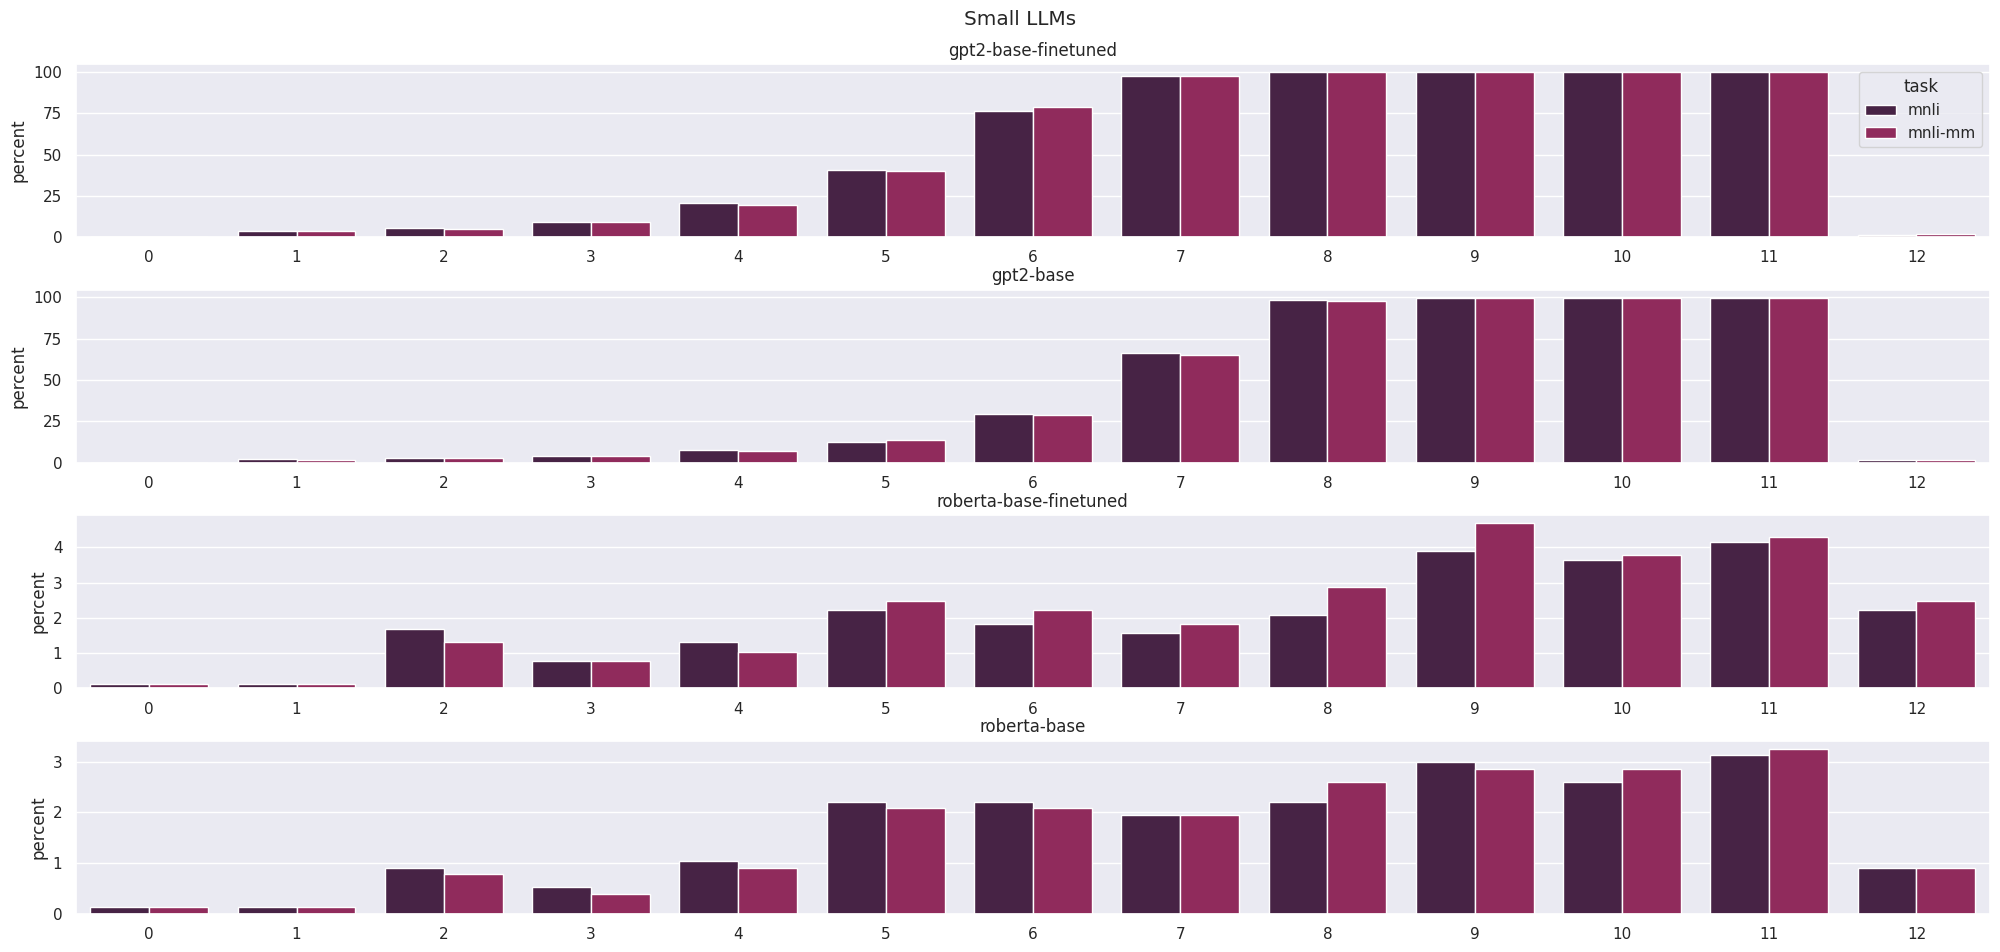

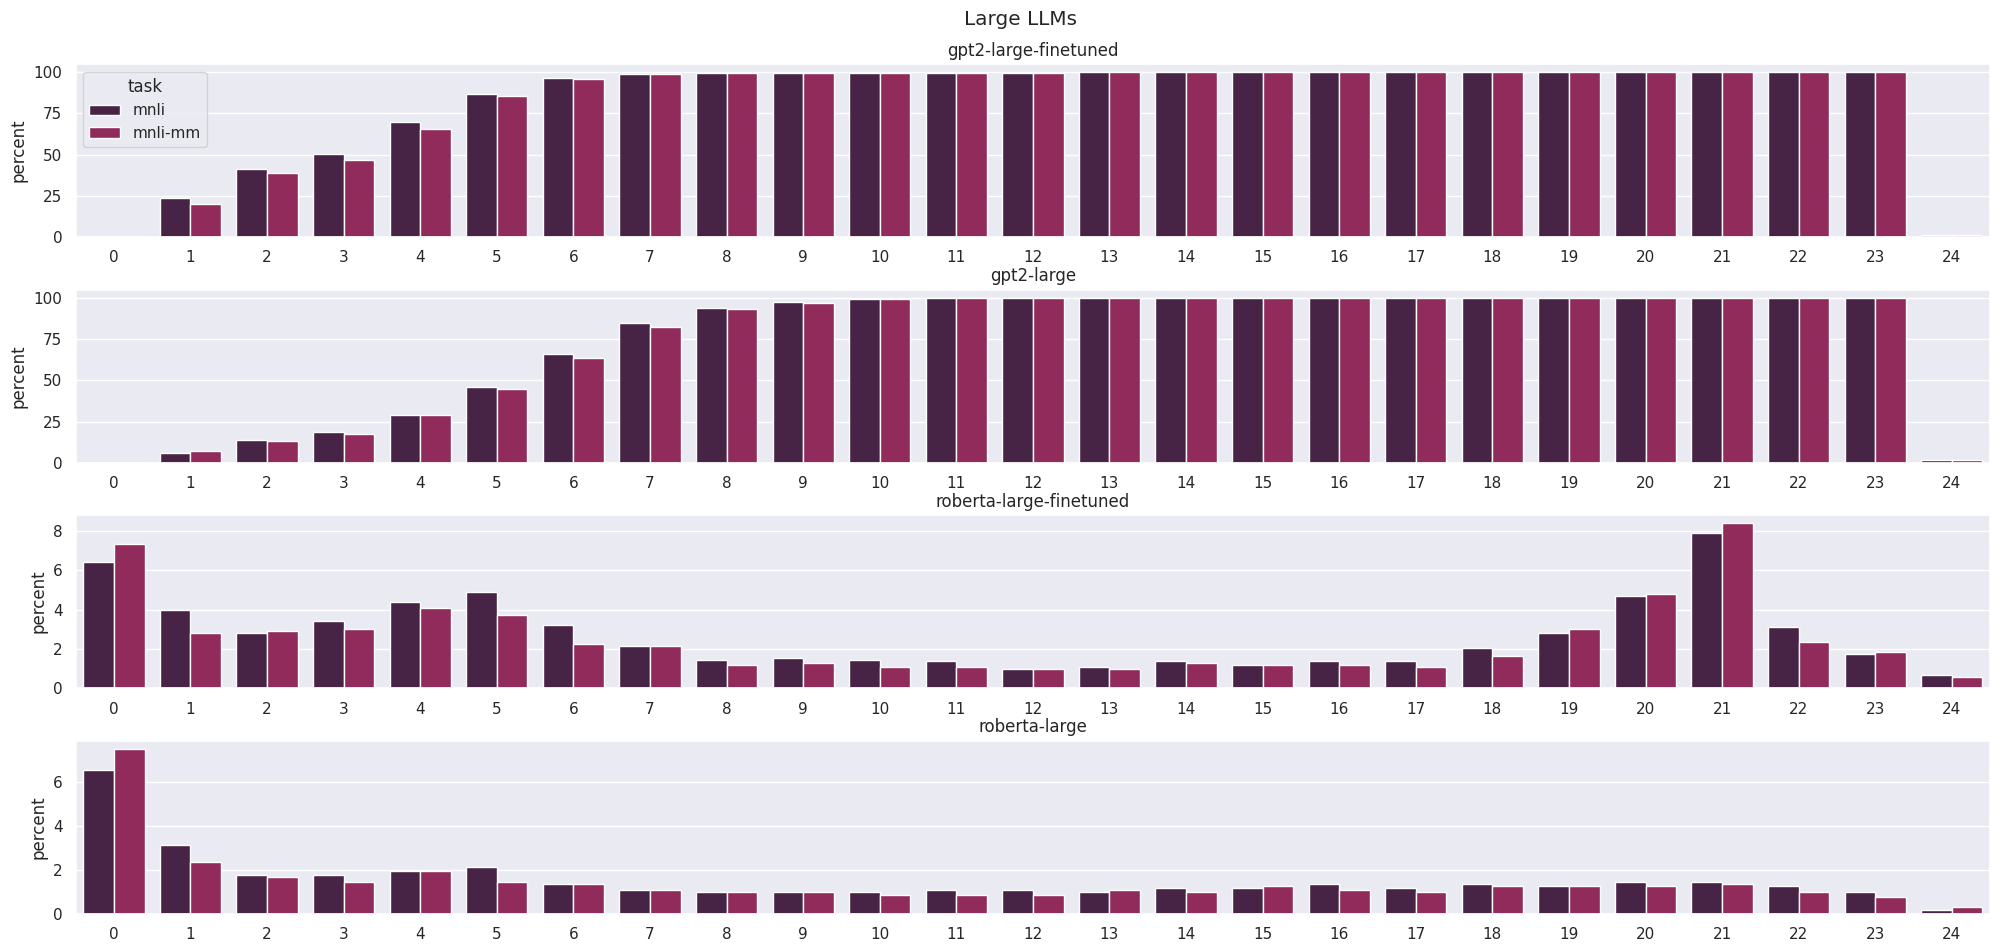

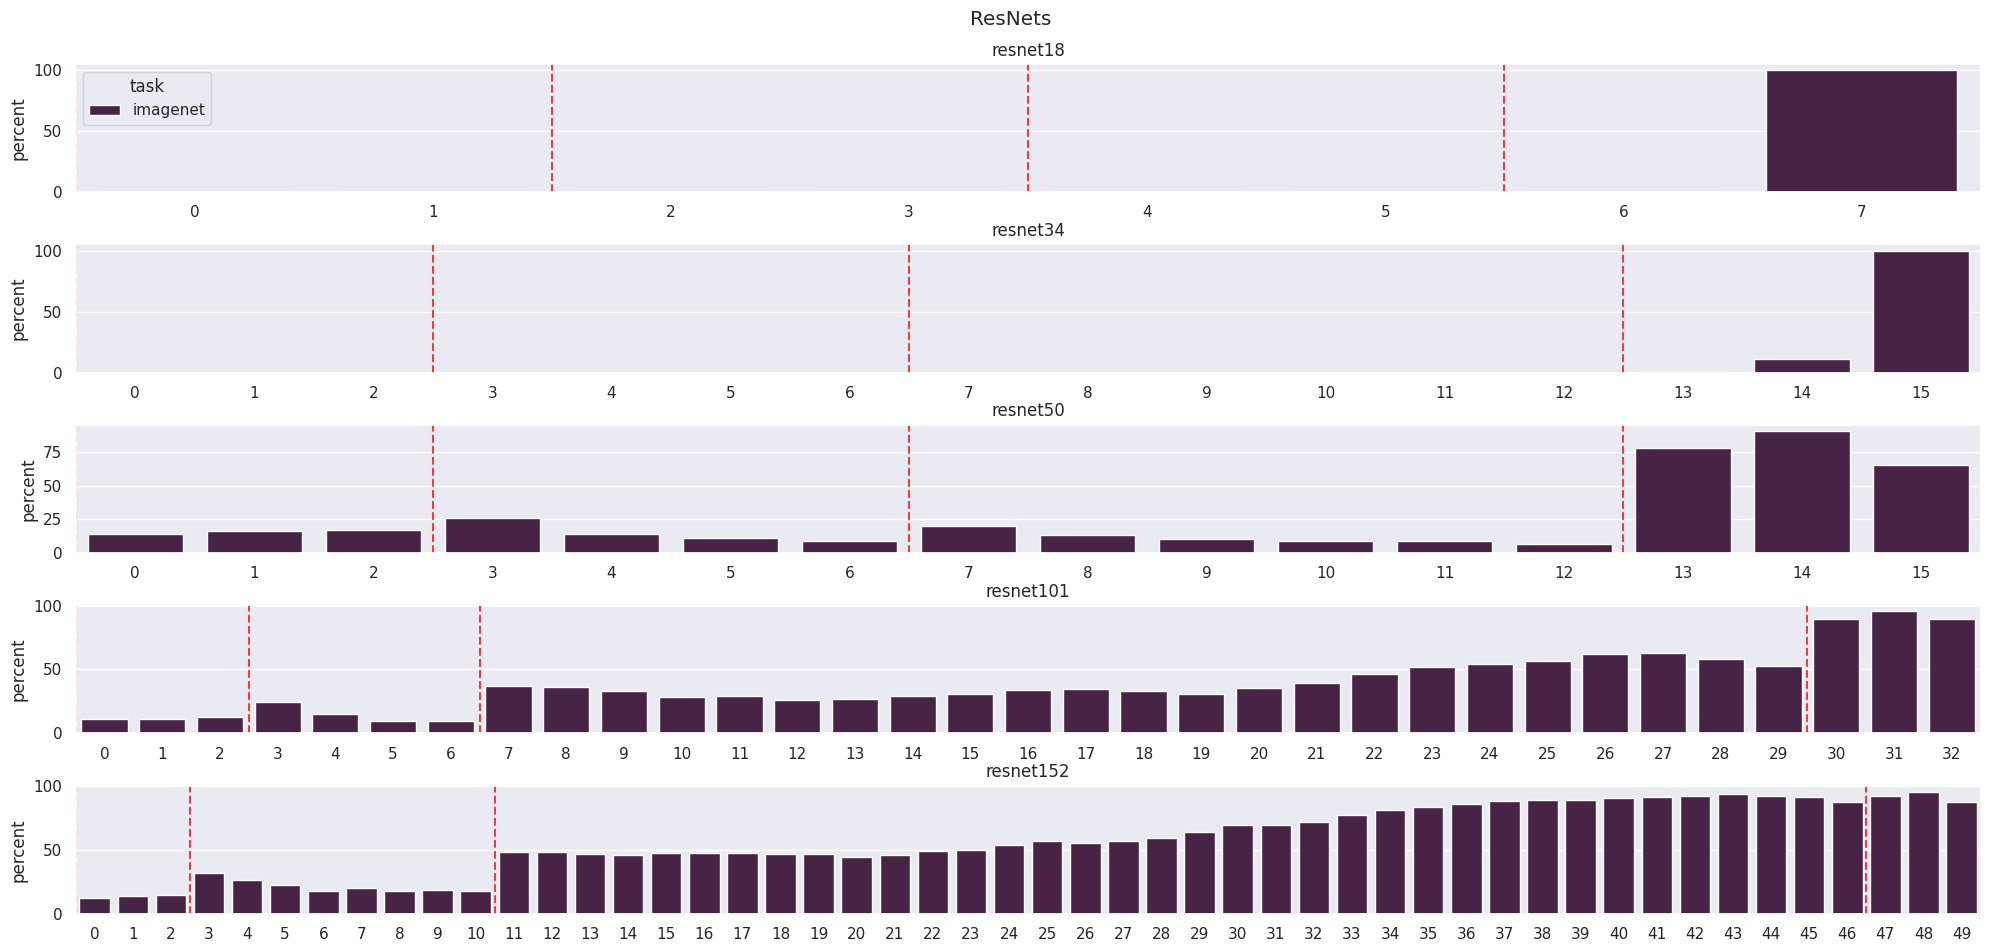

In [10]:
# plot outliers plot
plot_layer_chart(base_df, title="Small LLMs", column="percent")
plot_layer_chart(large_df, title="Large LLMs", column="percent")
plot_layer_chart(resnet_df, title="ResNets", column="percent")

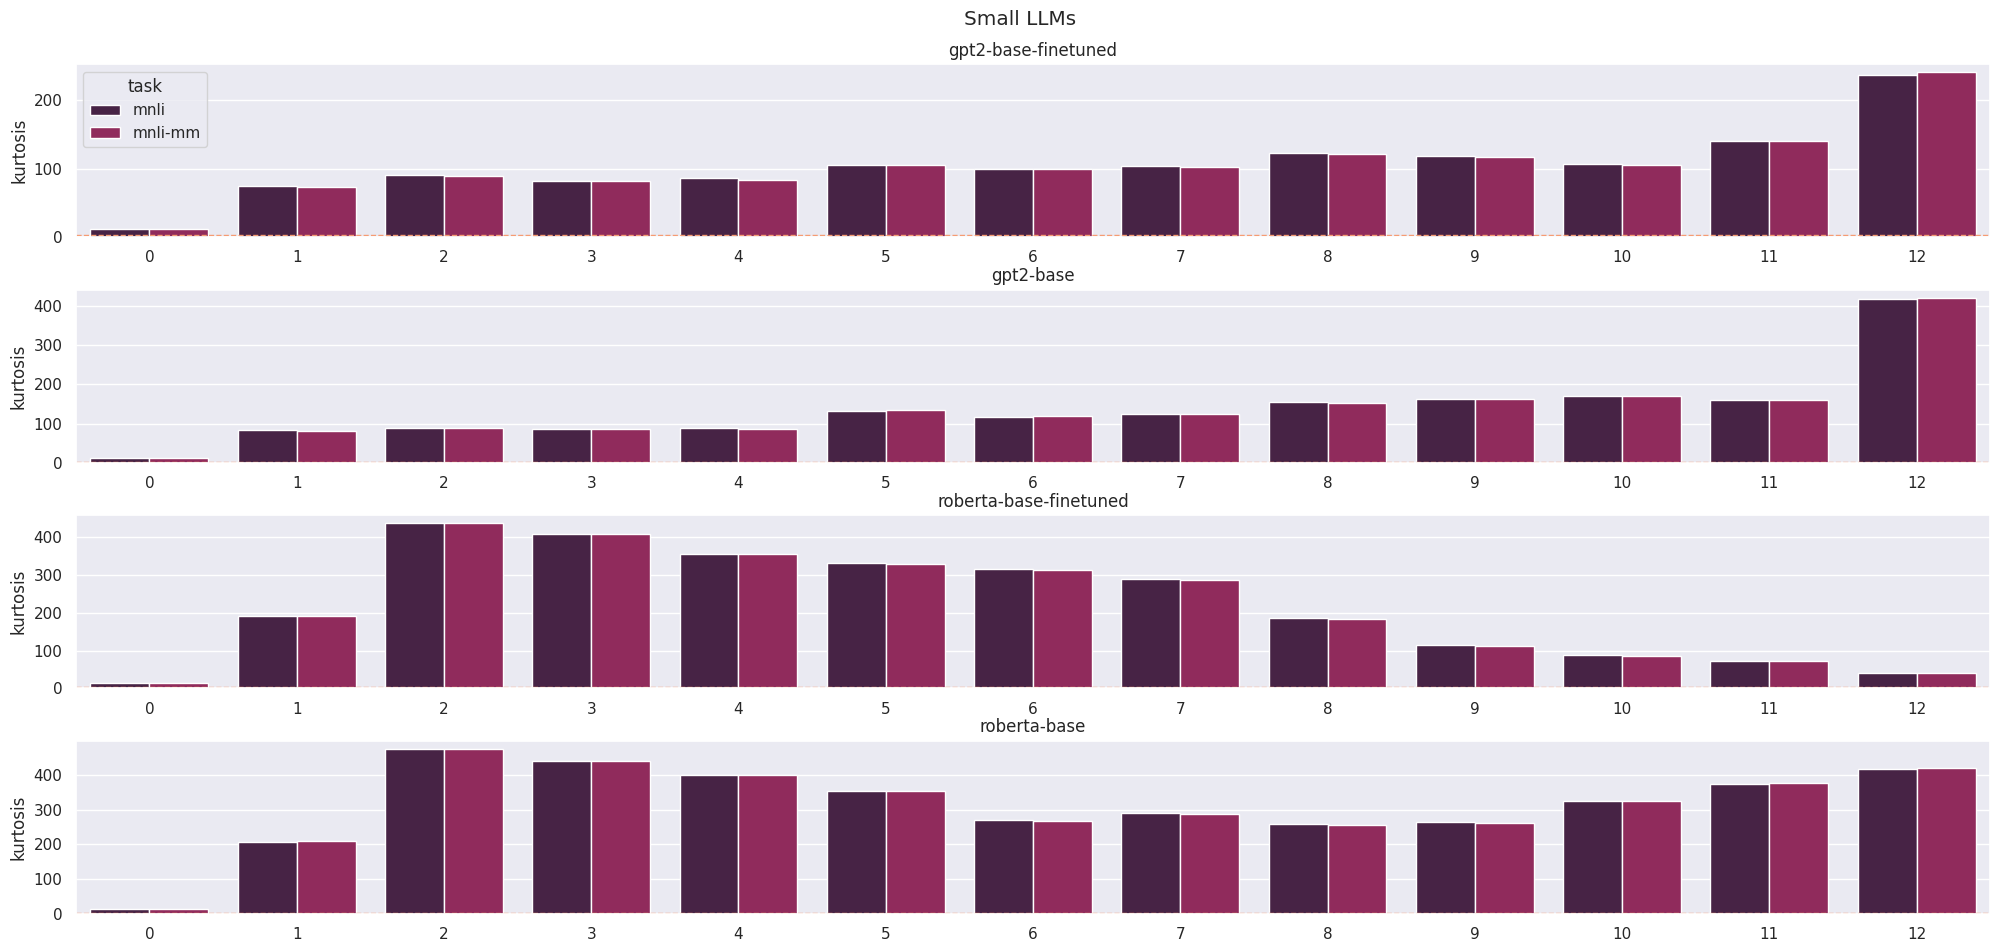

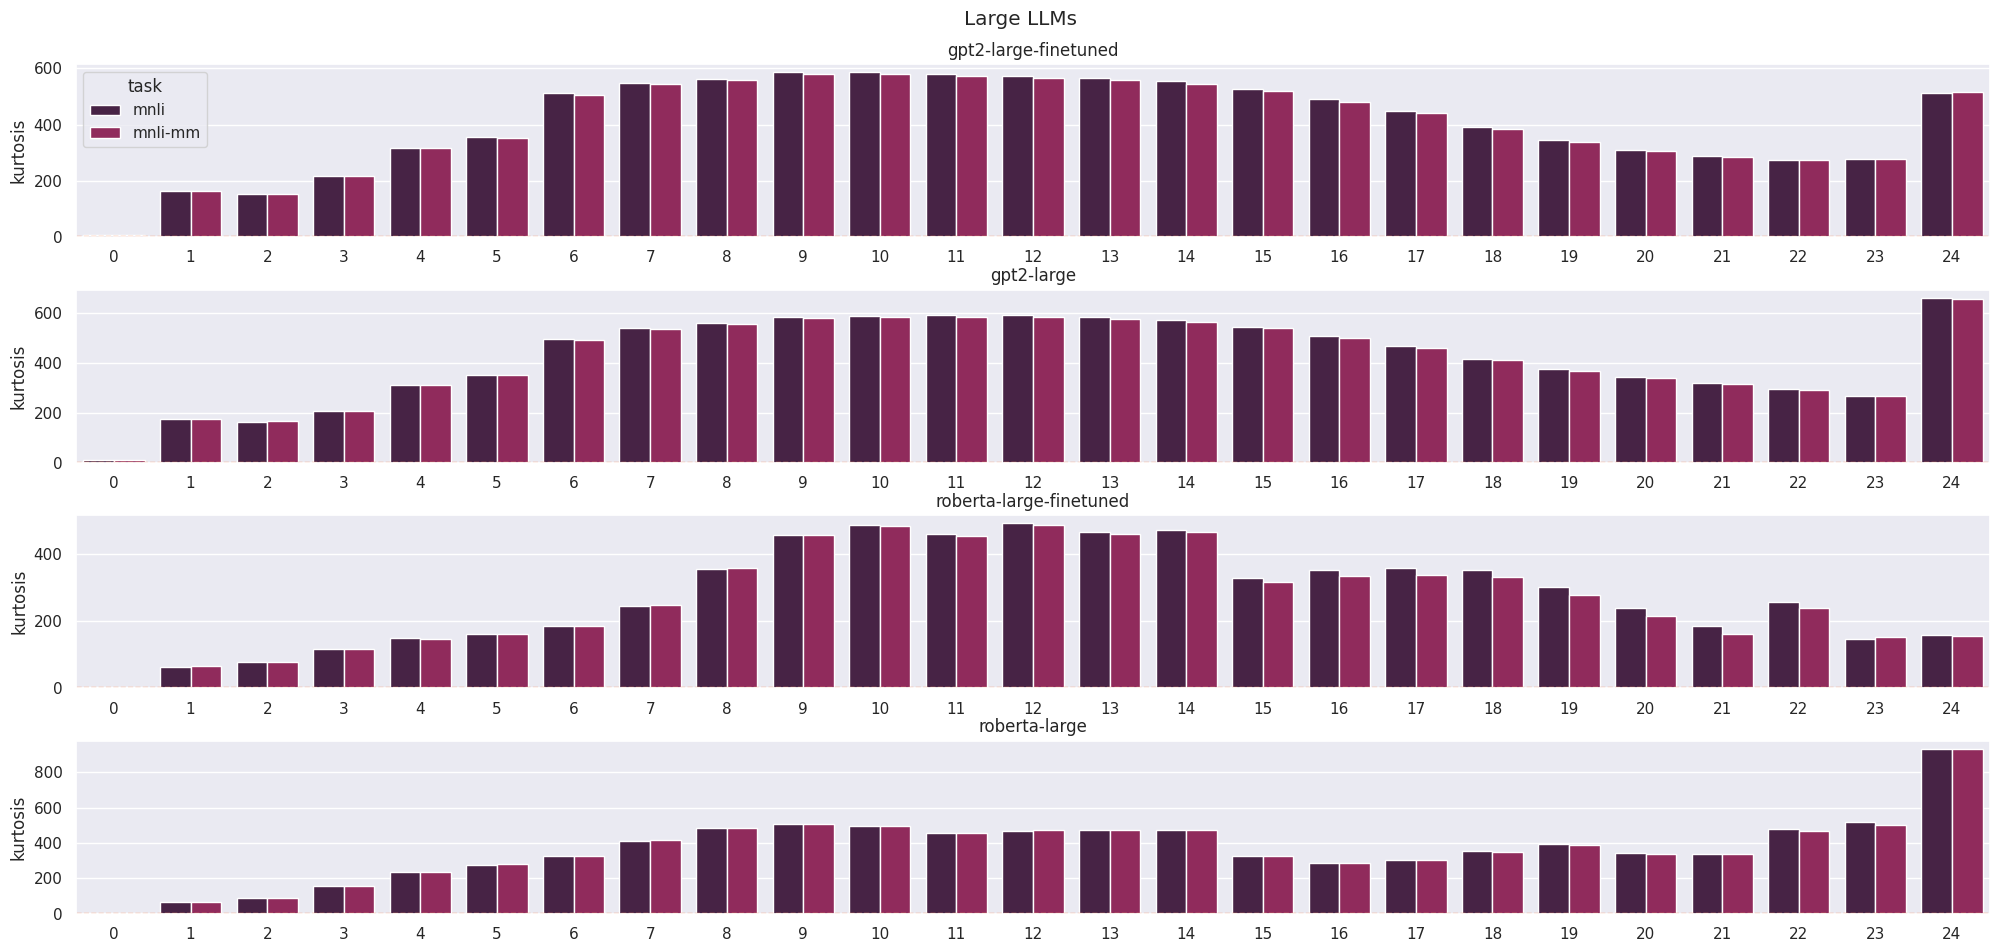

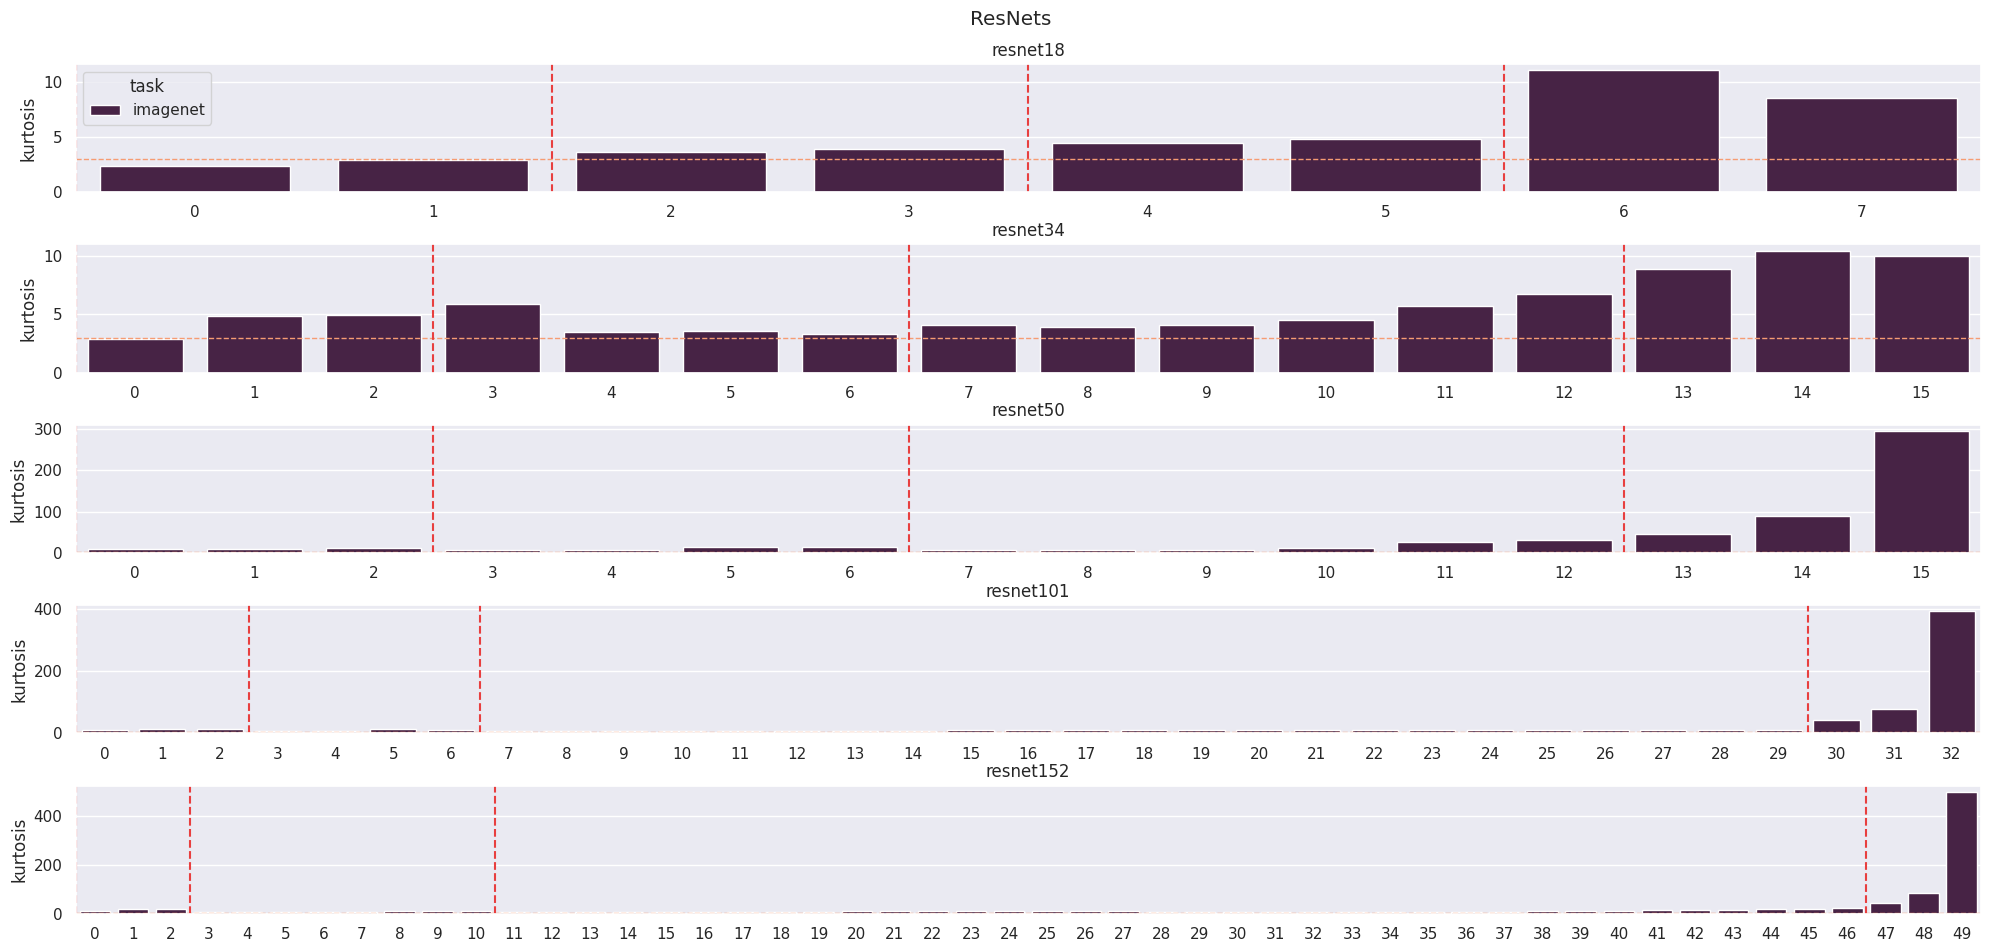

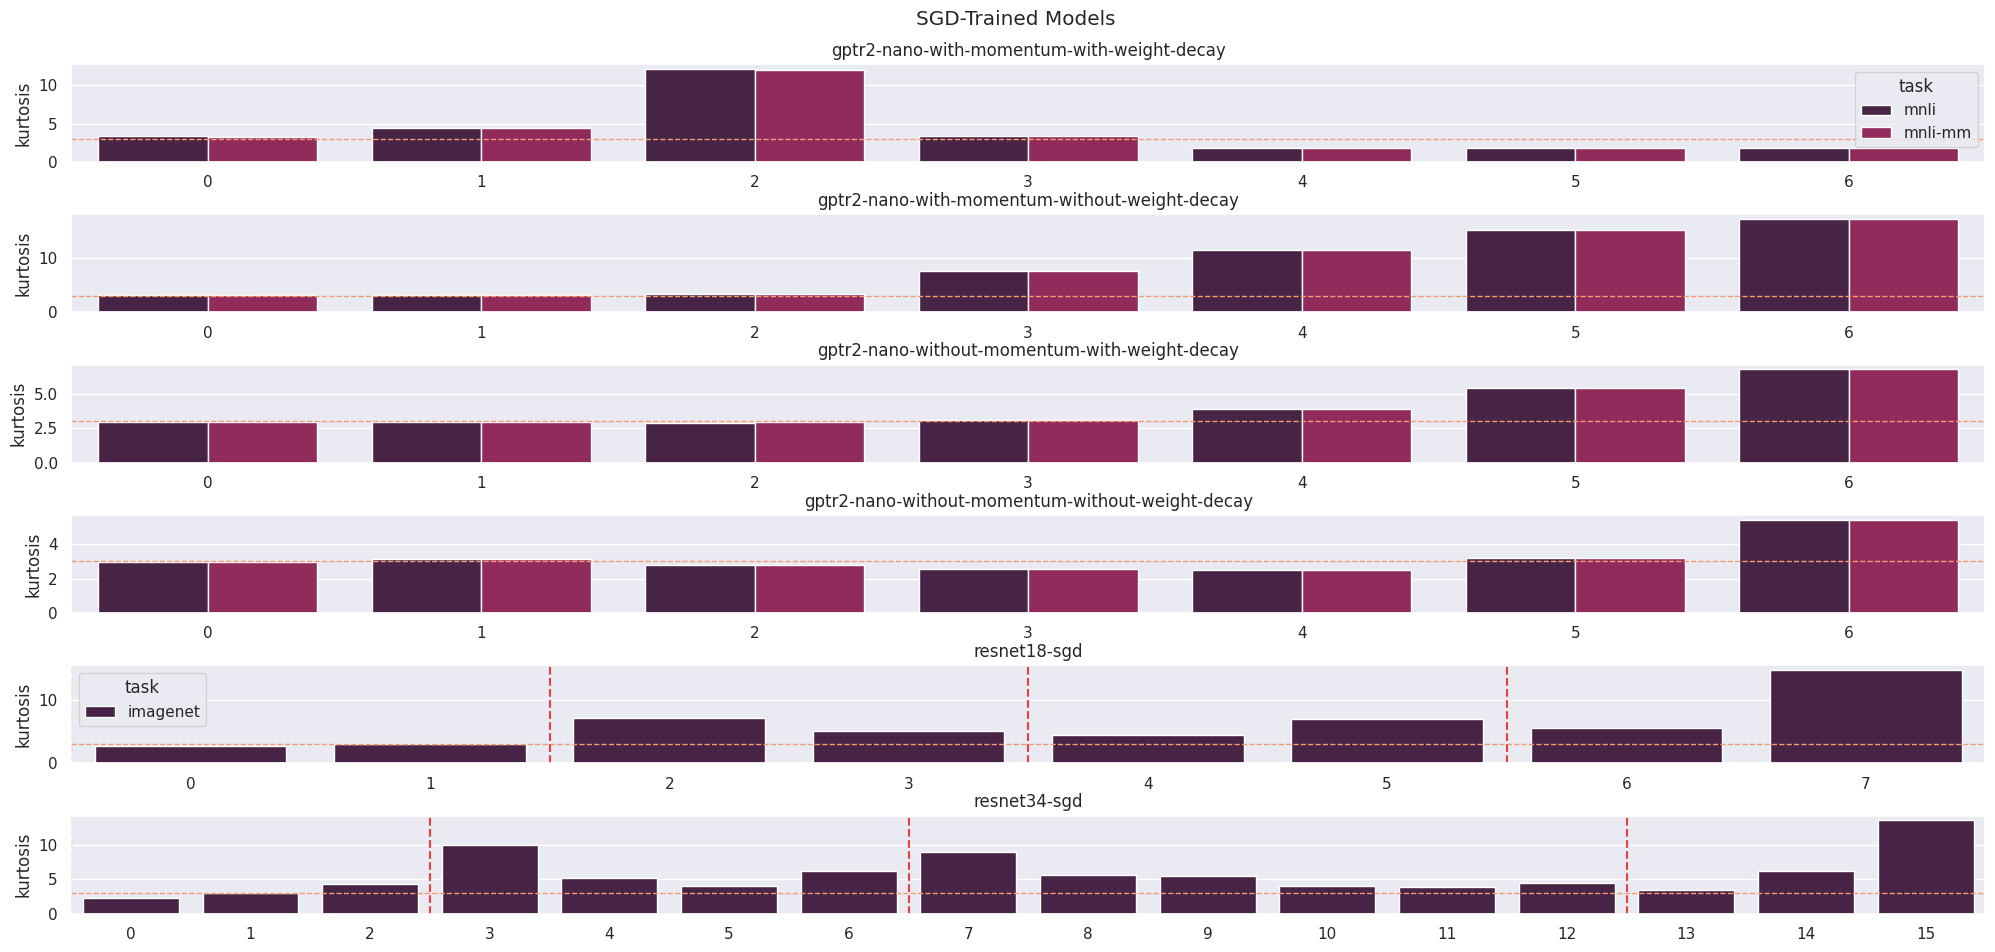

In [11]:
# function to draw line for kurtosis
kurtosis_line = functools.partial(draw_horizontal_line, y=3)
# plot kurtosis plots
plot_layer_chart(base_df, title="Small LLMs", column="kurtosis", transform=kurtosis_line)
plot_layer_chart(large_df, title="Large LLMs", column="kurtosis", transform=kurtosis_line)
plot_layer_chart(resnet_df, title="ResNets", column="kurtosis", transform=kurtosis_line)
plot_layer_chart(sgd_df, title="SGD-Trained Models", column="kurtosis", transform=kurtosis_line)

In [12]:
def plot_kurtosis(results: pd.DataFrame, title: str = None):
    """utility for plotting kurtosis and rotated kurtosis"""
    melted_results = pd.melt(results, id_vars=df.columns.difference(["kurtosis", "rotated-kurtosis"]), value_vars=["kurtosis", "rotated-kurtosis"], var_name="type", value_name="value")
    melted_results["kurtosis"] = melted_results["value"]
    plot_layer_chart(melted_results, title=title, column="value", split="type", transform=compose(add_values, functools.partial(draw_horizontal_line, y=3)))

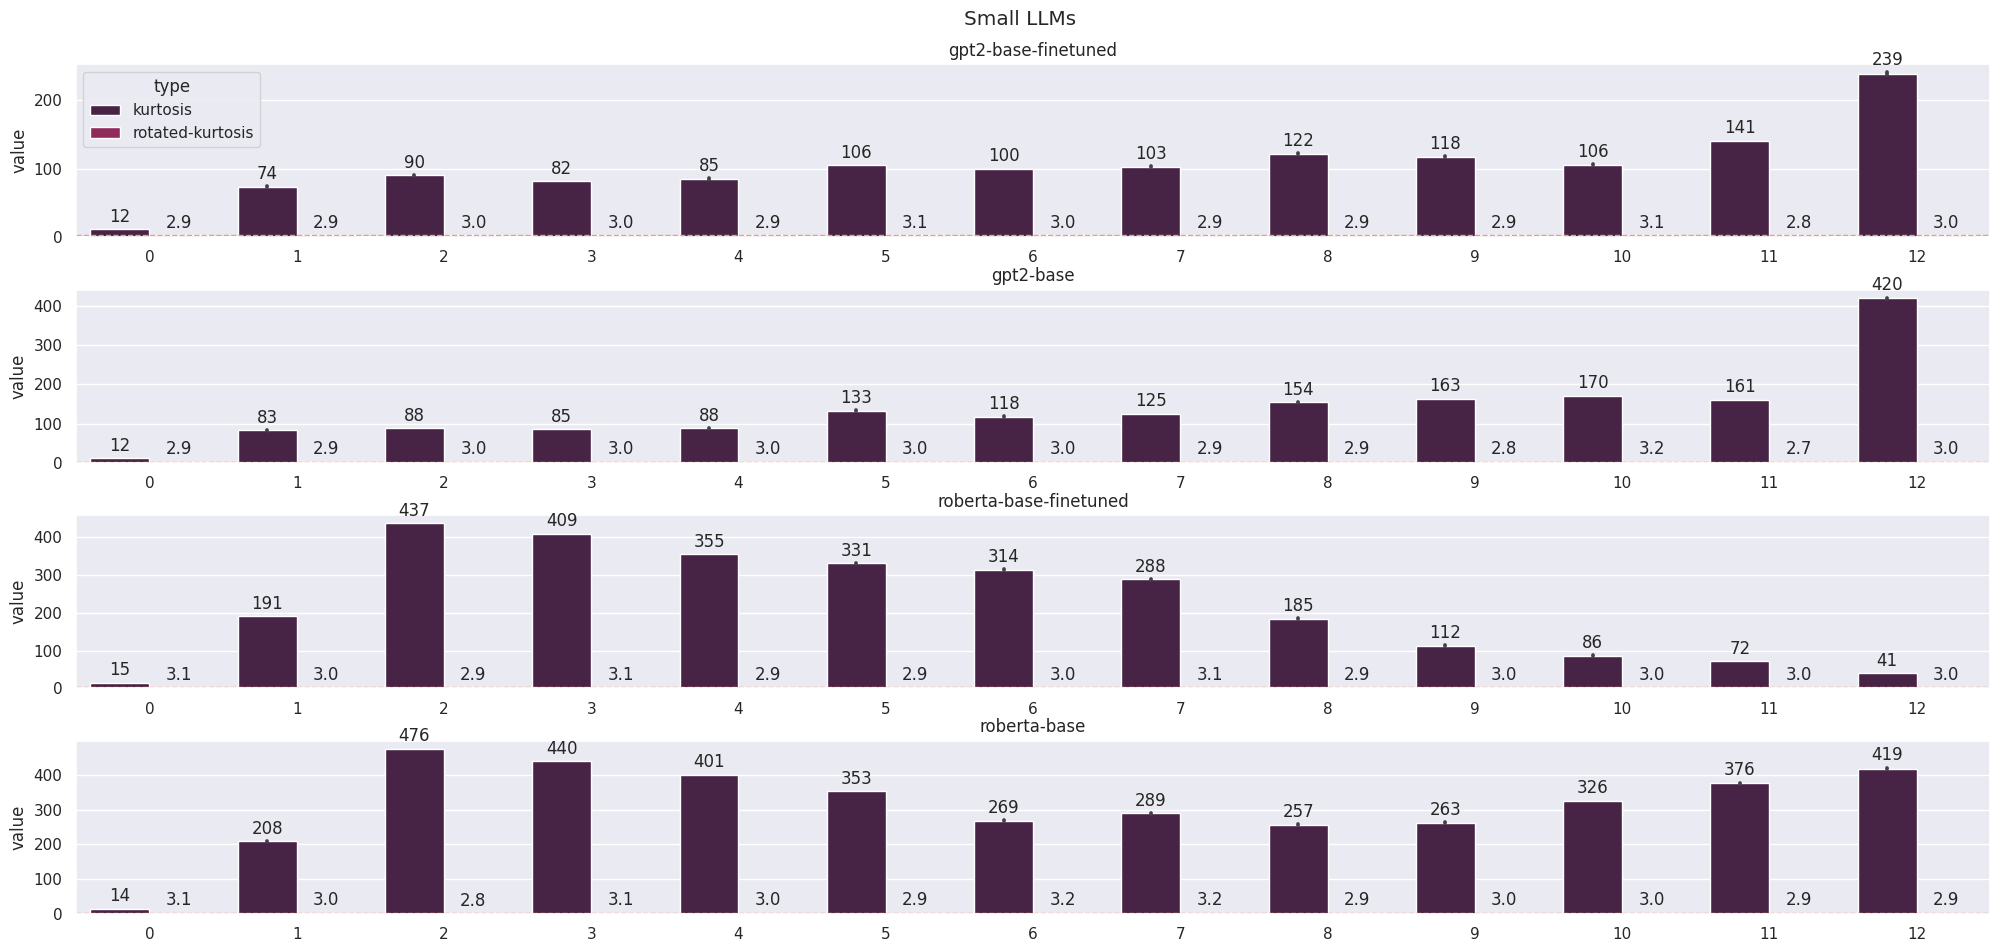

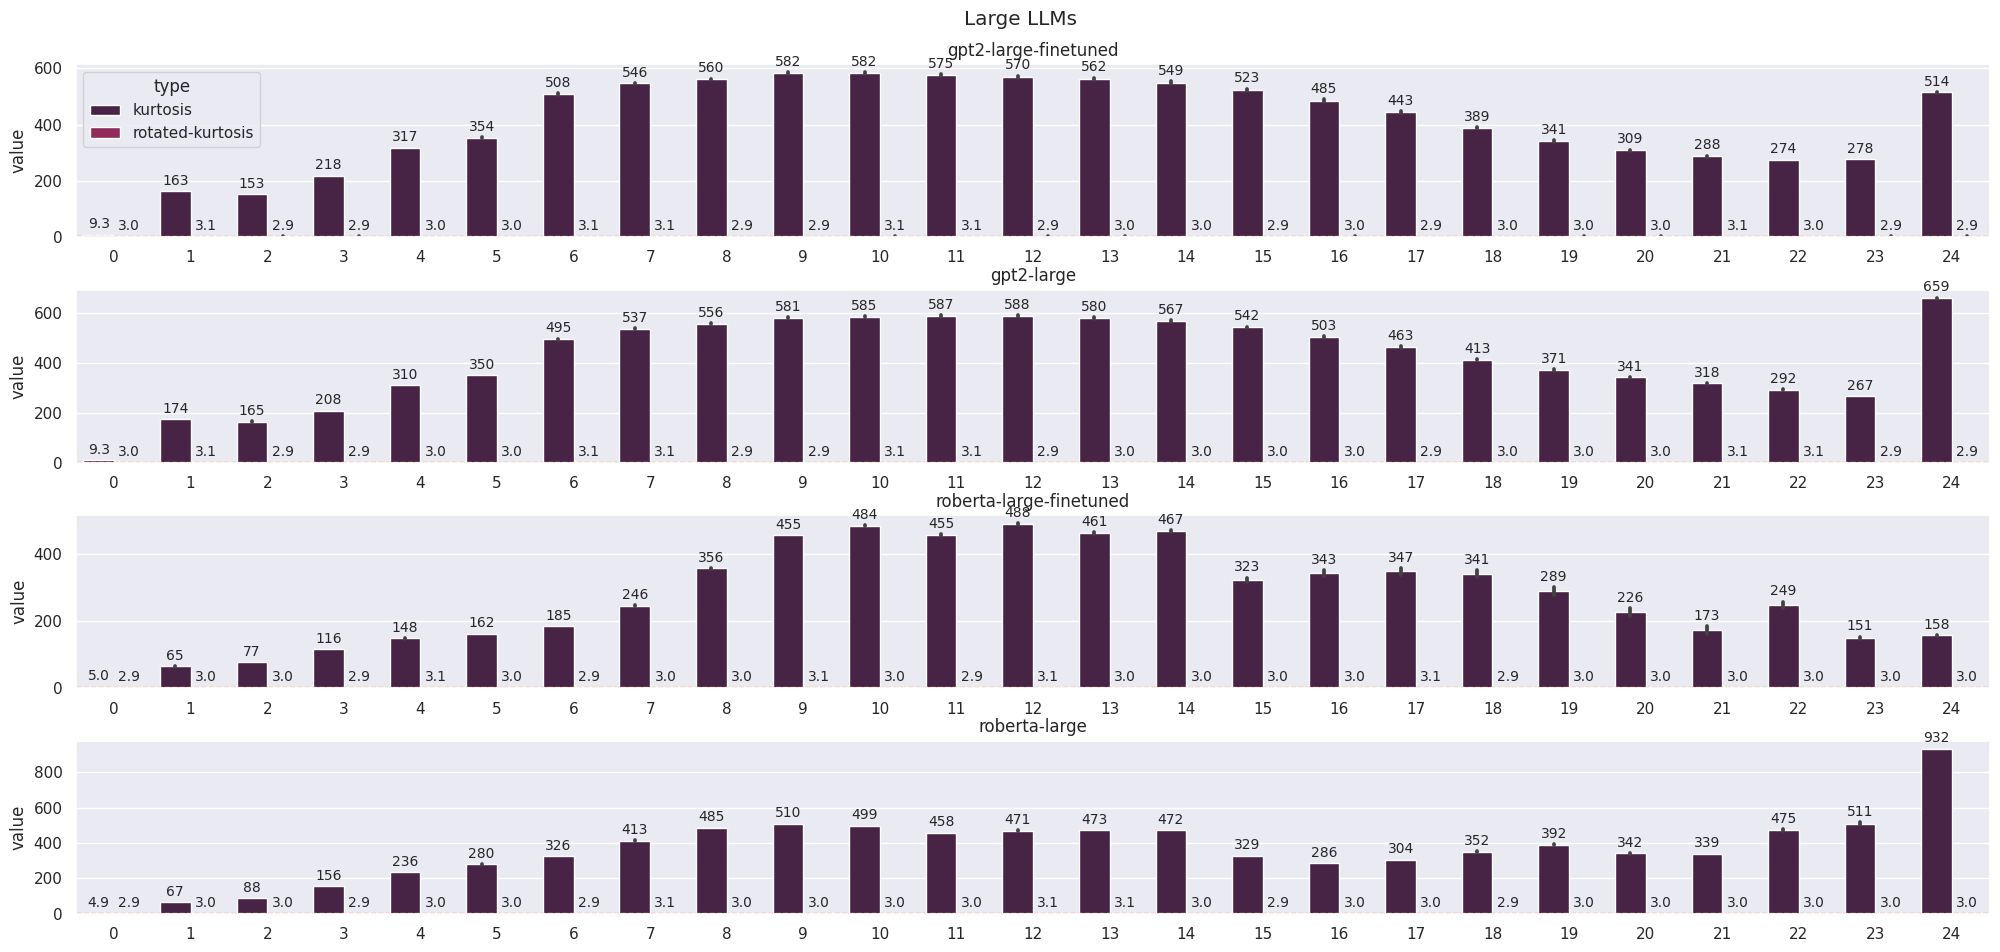

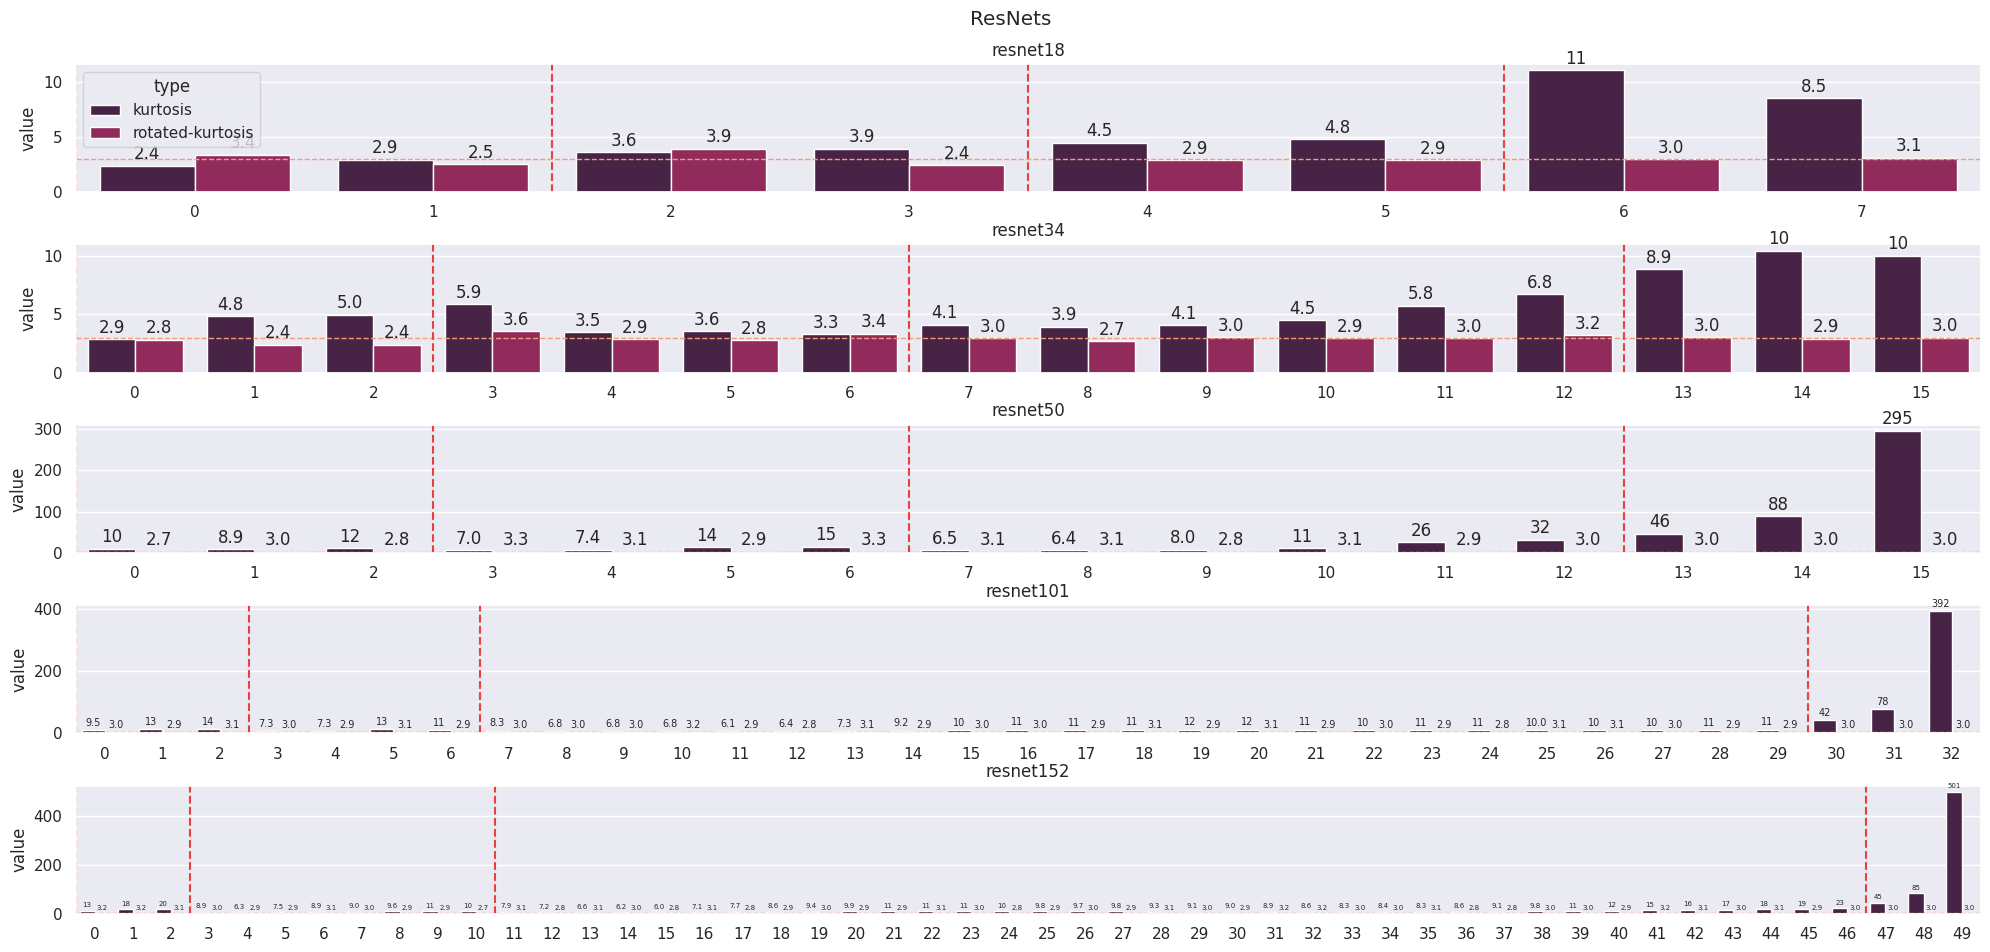

In [13]:
plot_kurtosis(base_df, title="Small LLMs")
plot_kurtosis(large_df, title="Large LLMs")
plot_kurtosis(resnet_df, title="ResNets")

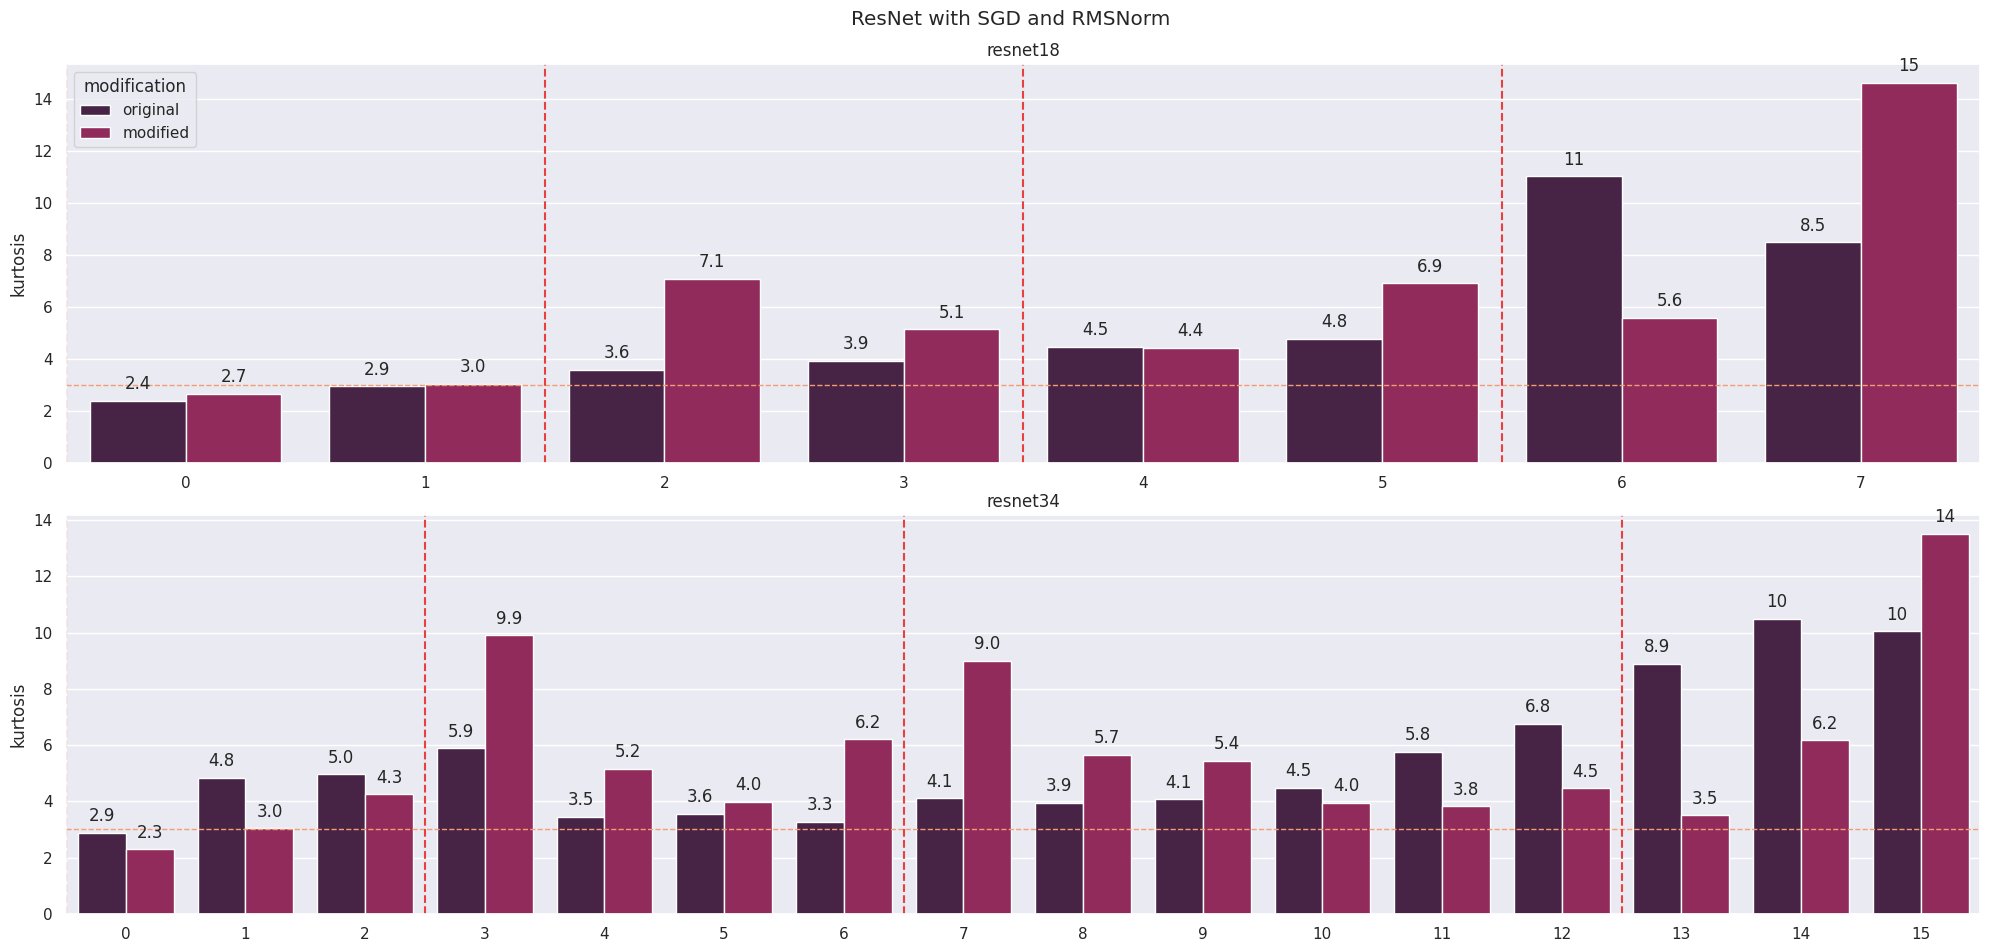

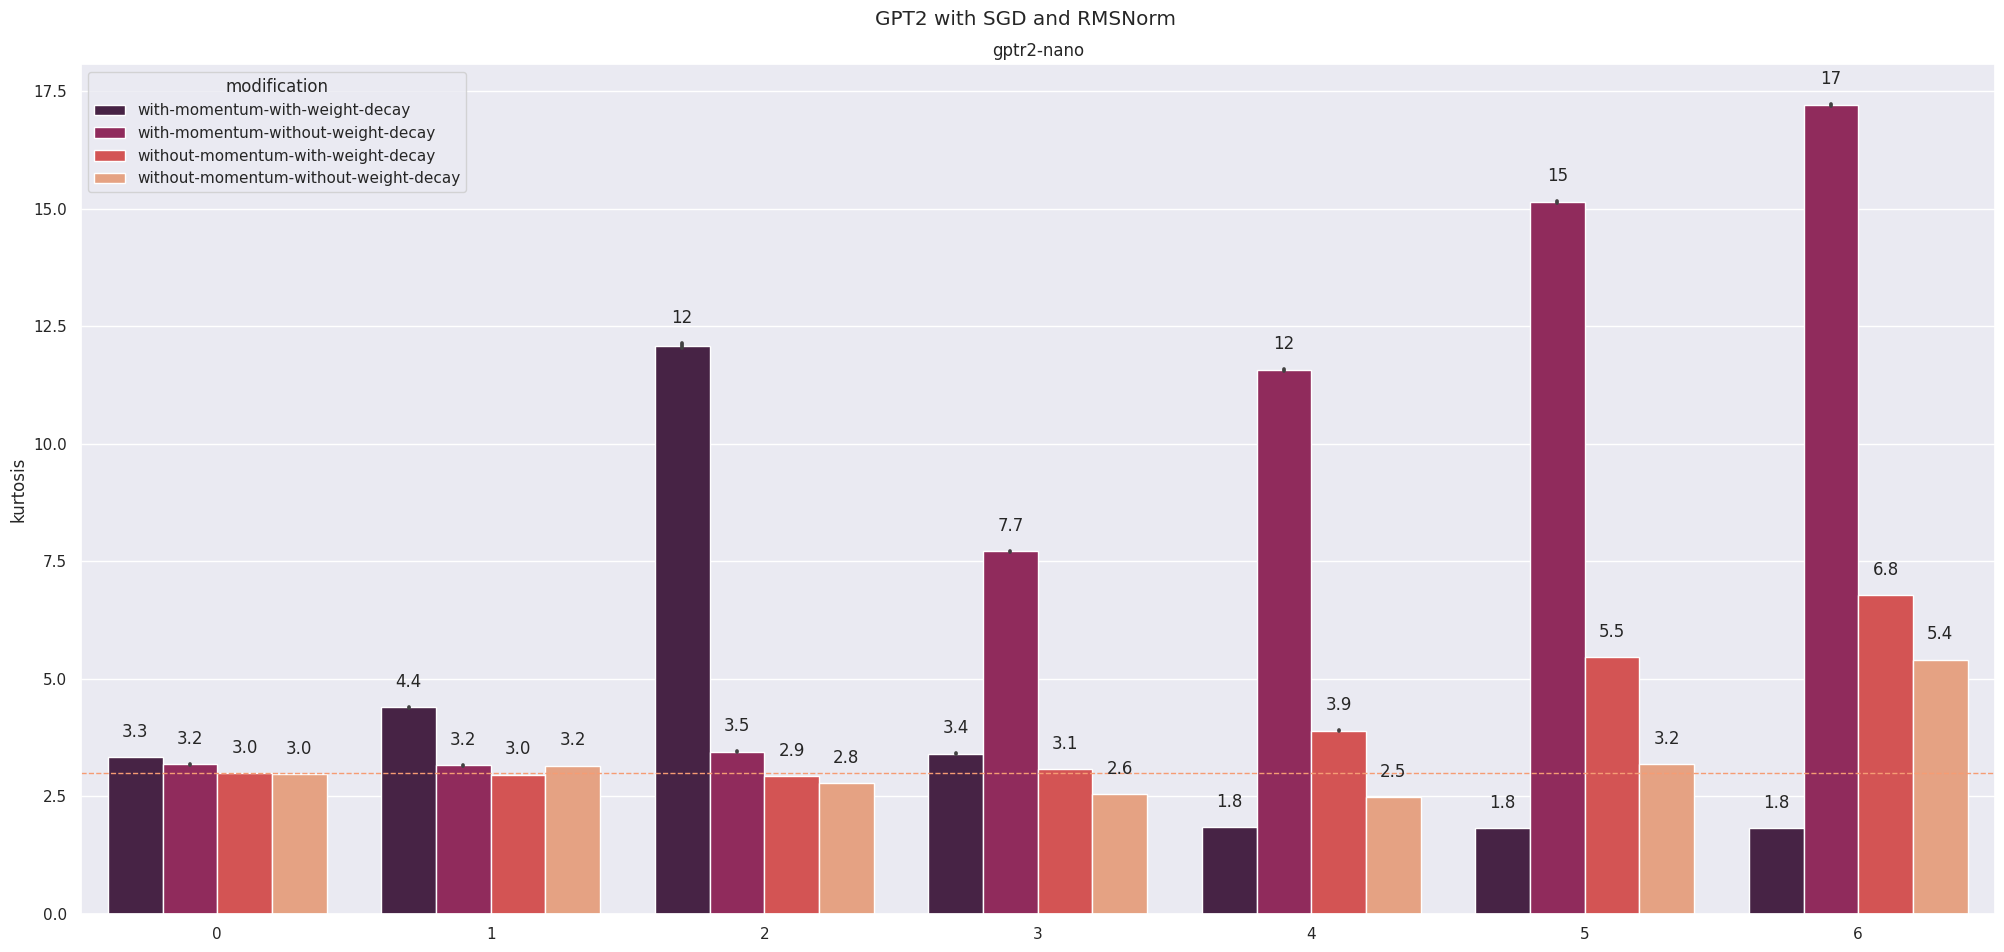

In [14]:
# plot a comparison of kurtoses for mixed models
plain_resnet_df = resnet_df.copy()
# copy original models
plain_resnet_df["model"] = resnet_df["model"] + "-original"
combined_results = pd.concat((plain_resnet_df, sgd_df))
# rename models
combined_results.replace(r"-sgd", r"-modified", inplace=True, regex=True)
# plot these models
models = ["resnet18", "resnet34", "gptr2-nano"]
# rename models into model and modification
combined_results["modification"] = combined_results["model"]
for model in models:
    # select the rows that start with the model name
    selected_rows = combined_results["model"].str.startswith(model)
    # change the modification to the last part of the model
    combined_results.loc[selected_rows, "modification"] = combined_results.loc[selected_rows, "model"].str.extract(f"(?<={model})-(.*)", expand=False)
    # group by original model
    combined_results.loc[selected_rows, "model"] = model
# delete unused rows
combined_results = combined_results[combined_results["model"].isin(models)]
# plot the data
plot_layer_chart(combined_results[combined_results["model"].str.startswith("resnet")], title="ResNet with SGD and RMSNorm", column="kurtosis", split="modification", transform=compose(add_values, functools.partial(draw_horizontal_line, y=3)))
plot_layer_chart(combined_results[combined_results["model"] == "gptr2-nano"], title="GPT2 with SGD and RMSNorm", column="kurtosis", split="modification", transform=compose(add_values, functools.partial(draw_horizontal_line, y=3)))

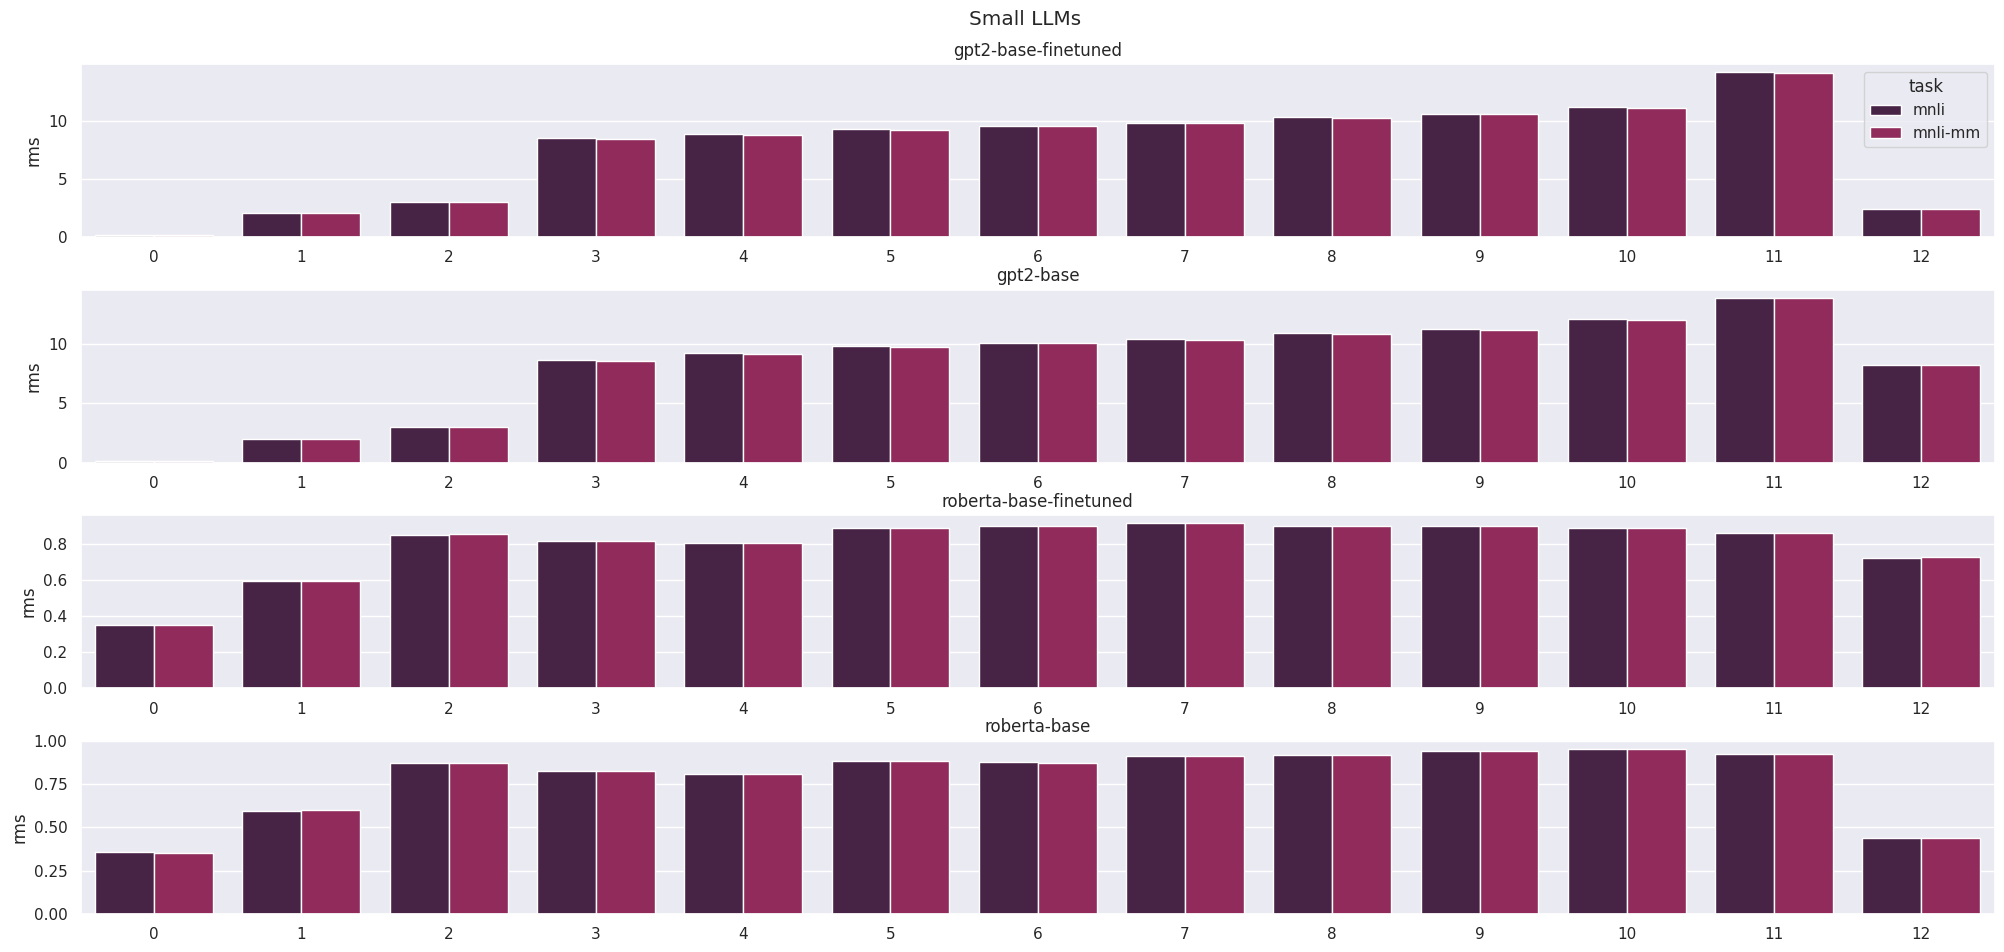

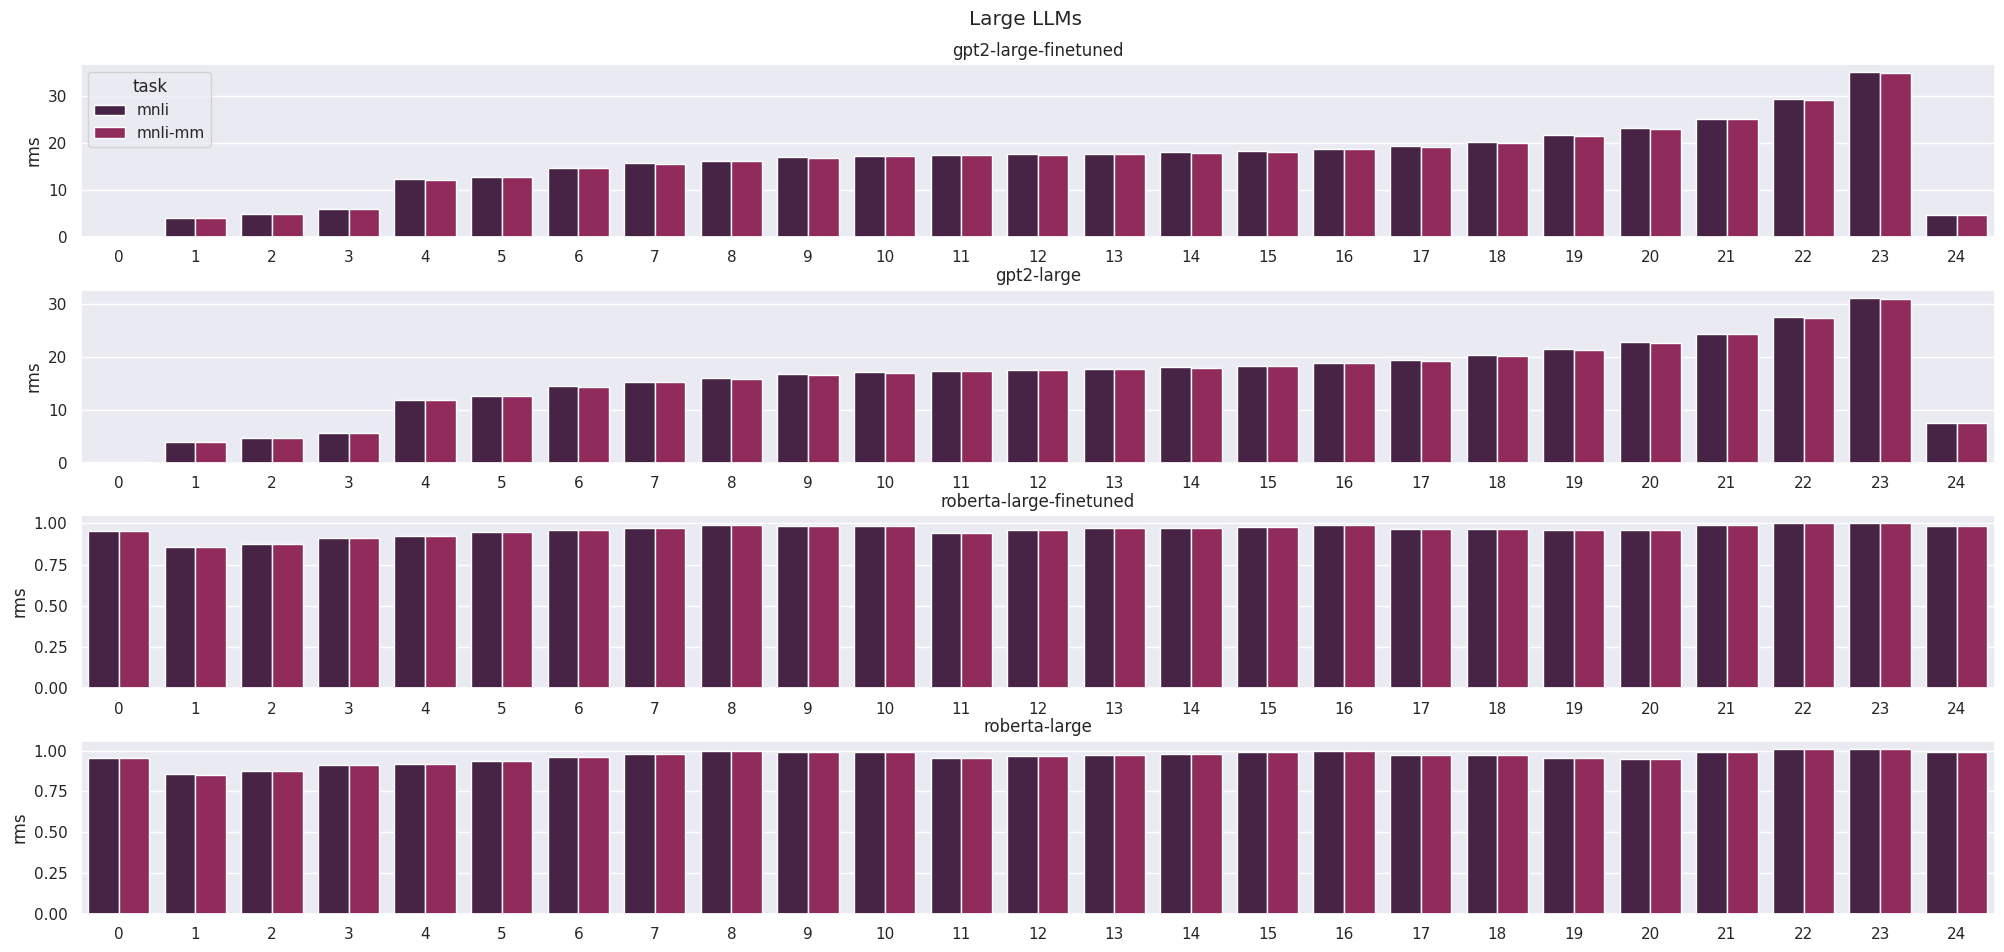

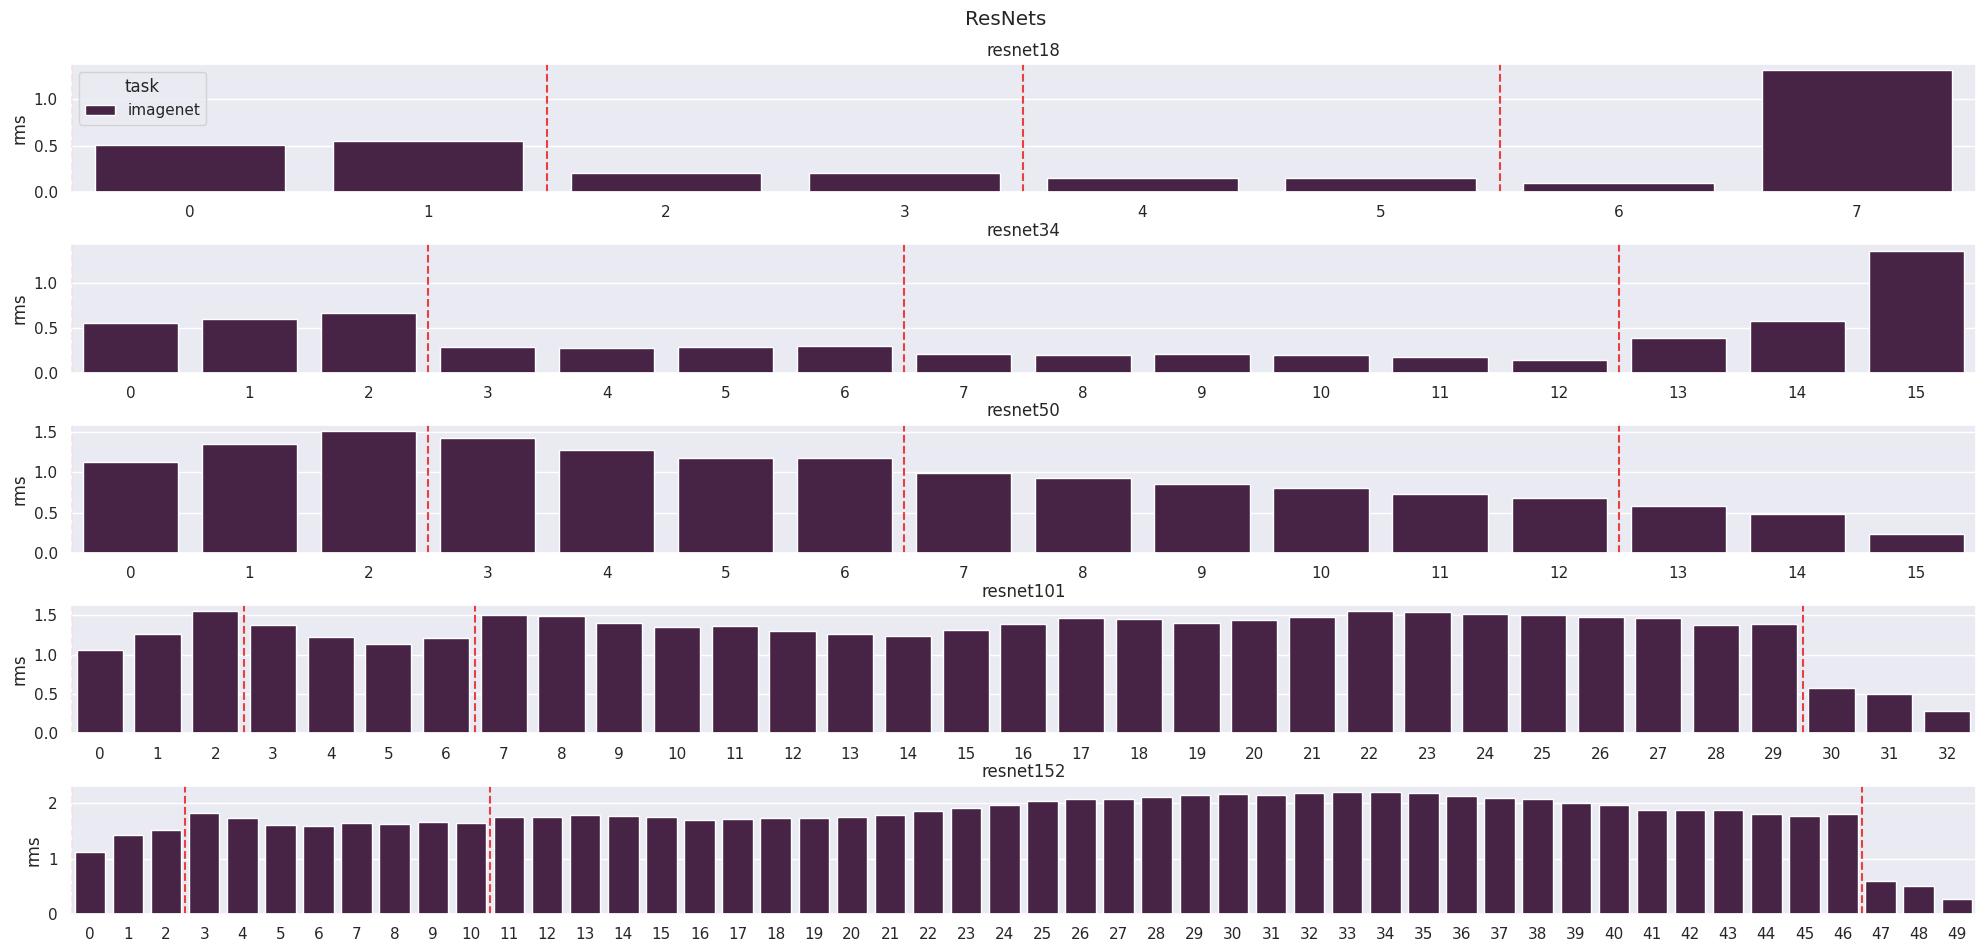

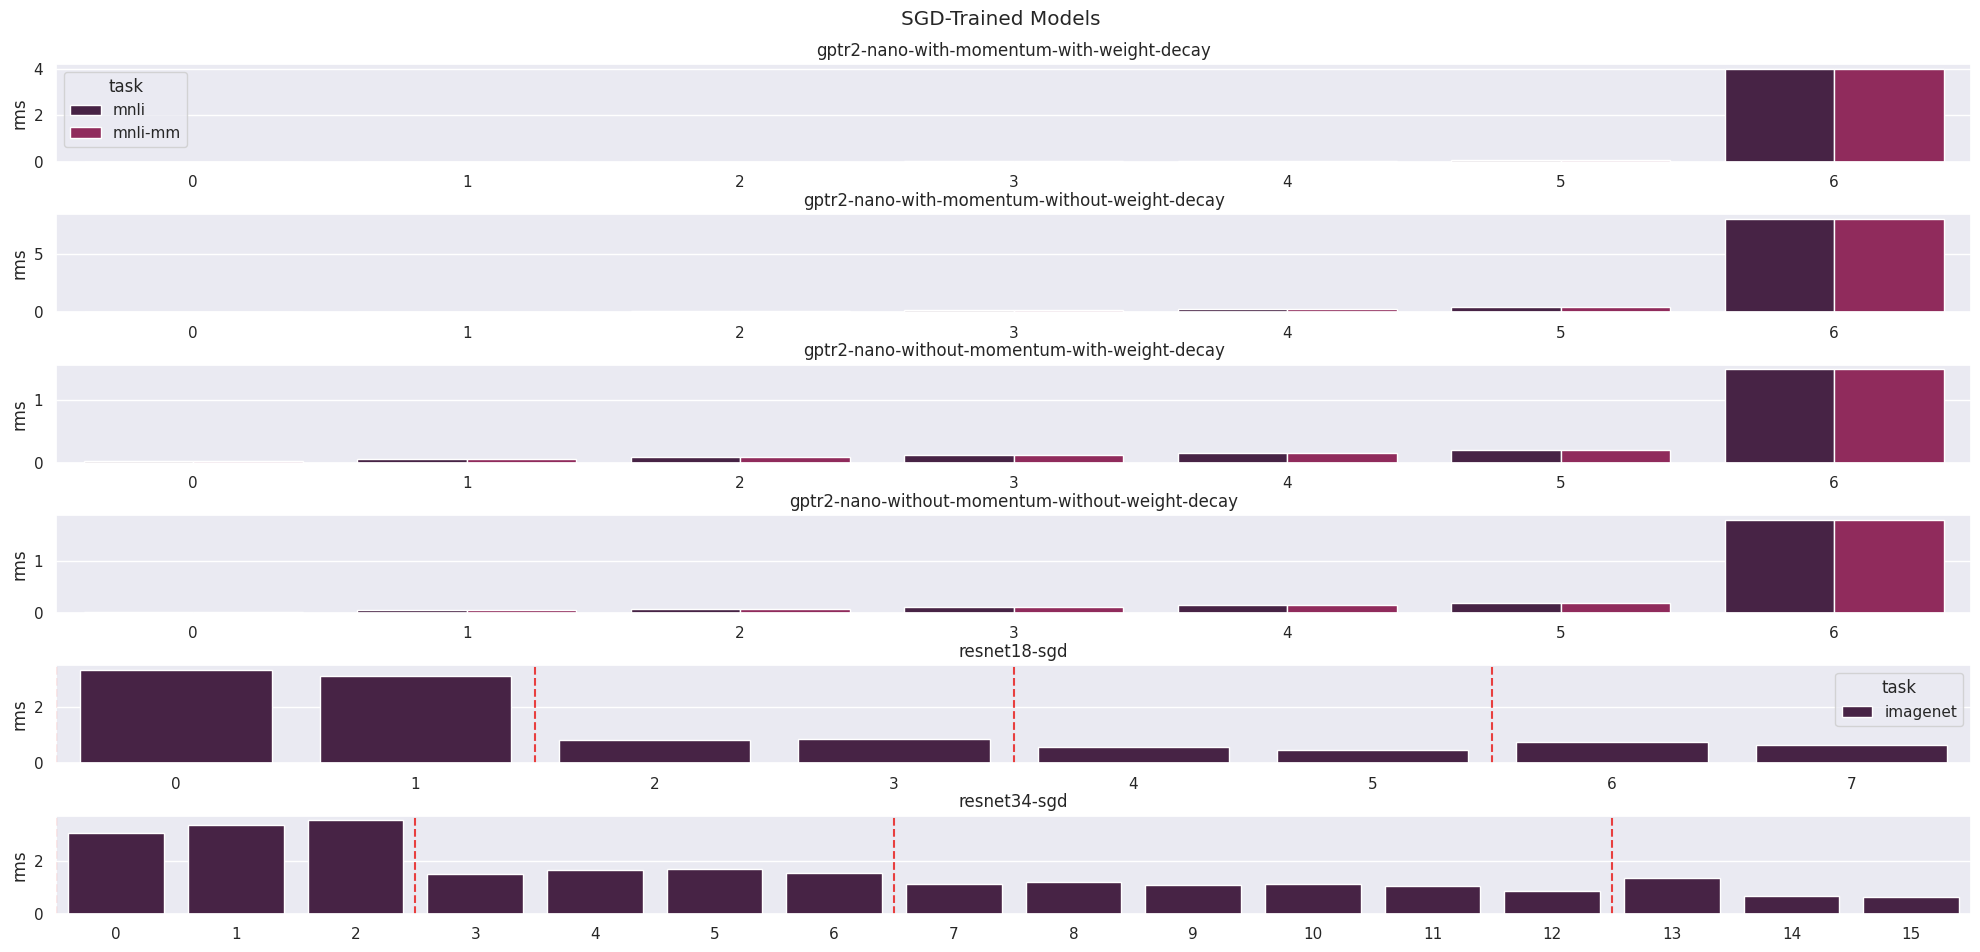

In [15]:
# plot RMS
plot_layer_chart(base_df, title="Small LLMs", column="rms")
plot_layer_chart(large_df, title="Large LLMs", column="rms")
plot_layer_chart(resnet_df, title="ResNets", column="rms")
plot_layer_chart(sgd_df, title="SGD-Trained Models", column="rms")

In [16]:
def plot_accuracy(results: pd.DataFrame, title: str = None, num_classes: int = 10):
    """plot the accuracy of models with different layer ablations"""
    # split into forward and backward accuracy
    melted_results = pd.melt(results, id_vars=df.columns.difference(["accuracy", "reversed-accuracy"]), value_vars=["accuracy", "reversed-accuracy"], var_name="direction", value_name="score")
    # ignore models that didn't record accuracy
    melted_results = melted_results.dropna(subset=["score"])
    # convert to percentage
    melted_results["accuracy"] = melted_results["score"].apply(lambda scores: [score * 100 for score in scores])
    # plot the data
    plot_layer_chart(melted_results, title=title, column="accuracy", split="direction", transform=compose(functools.partial(draw_horizontal_line, y=100 / num_classes), add_values))

In [17]:
def reverse(series: pd.Series) -> pd.Series:
    """utility to reverse a list in a series"""
    return series.map(compose(list, reversed), na_action="ignore")

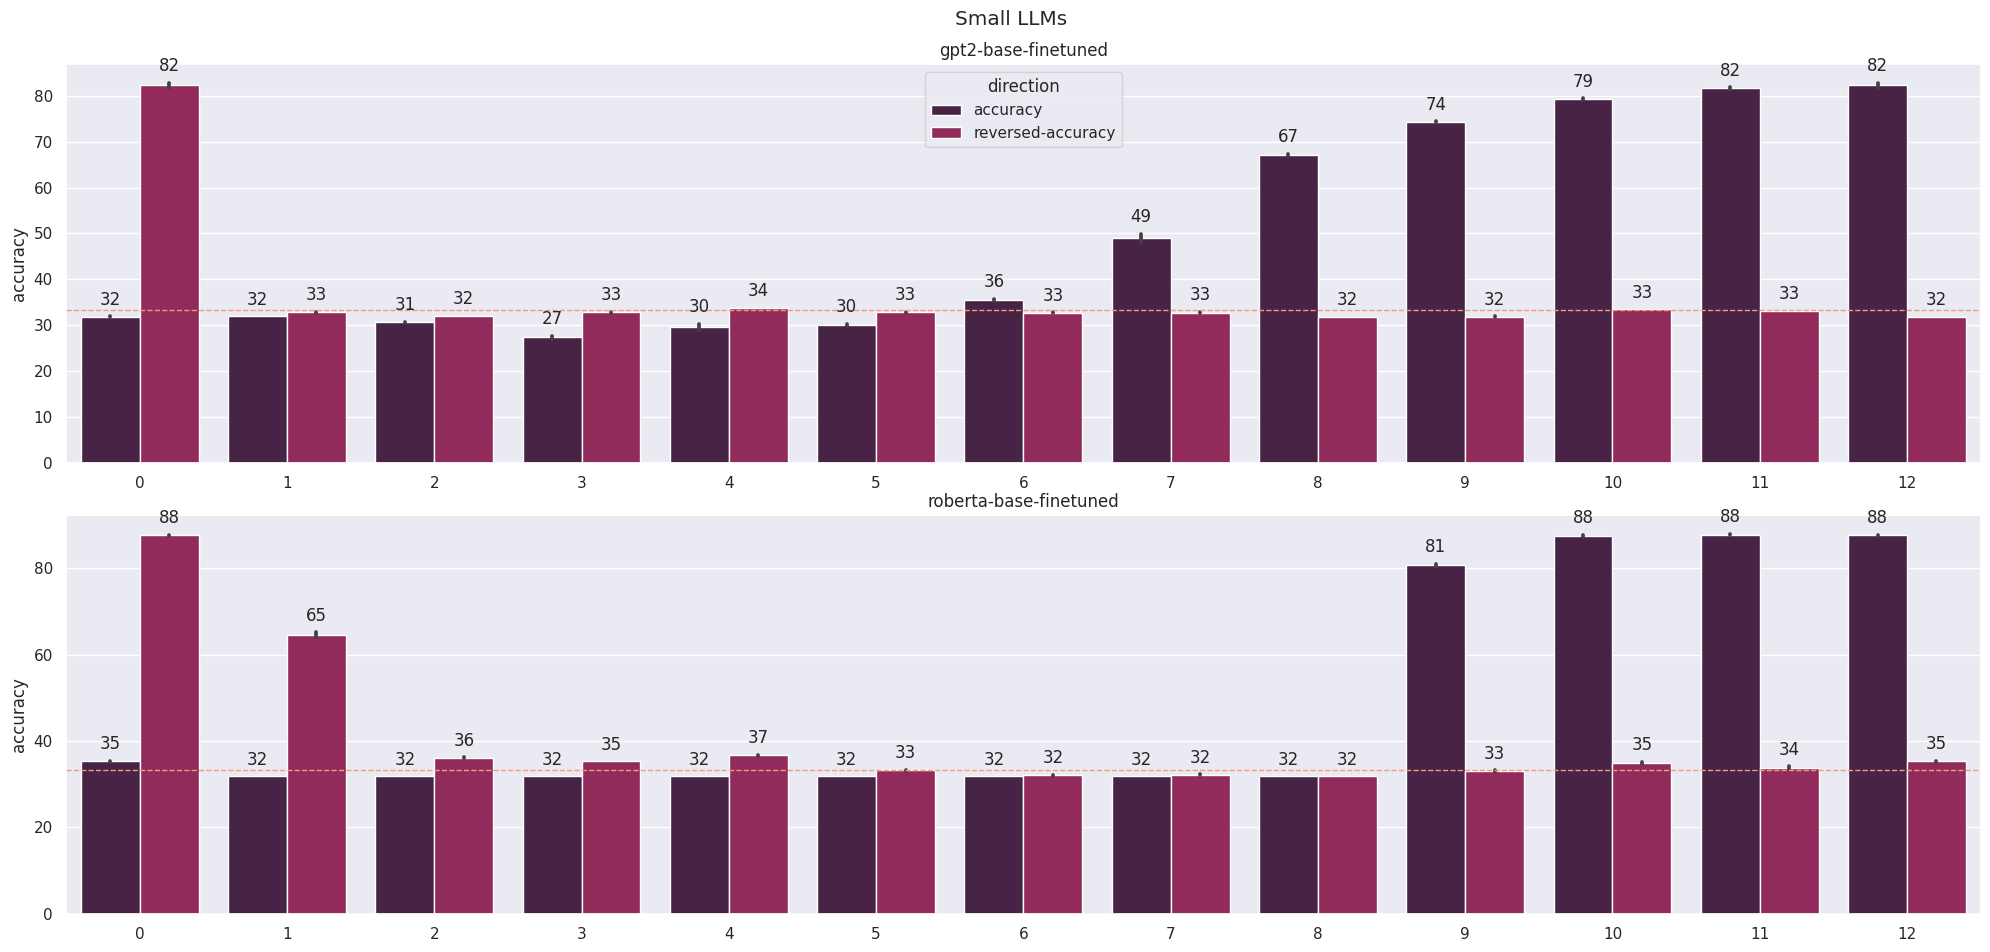

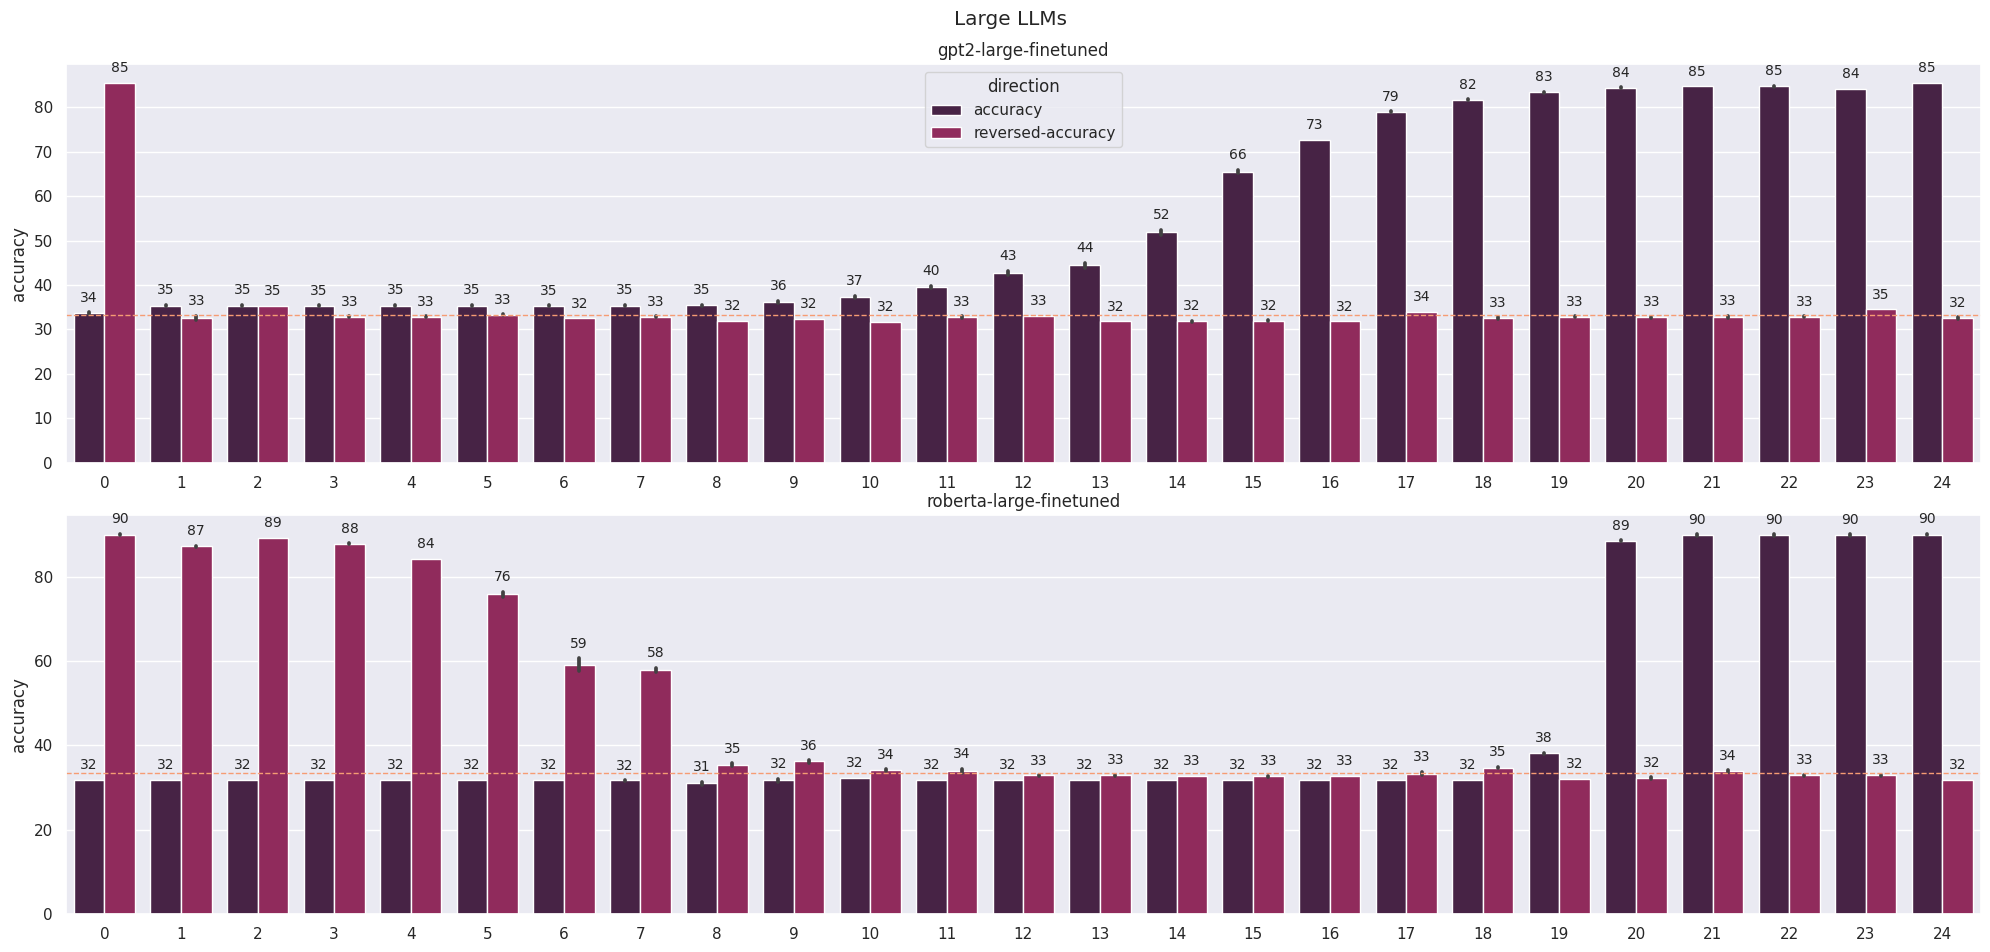

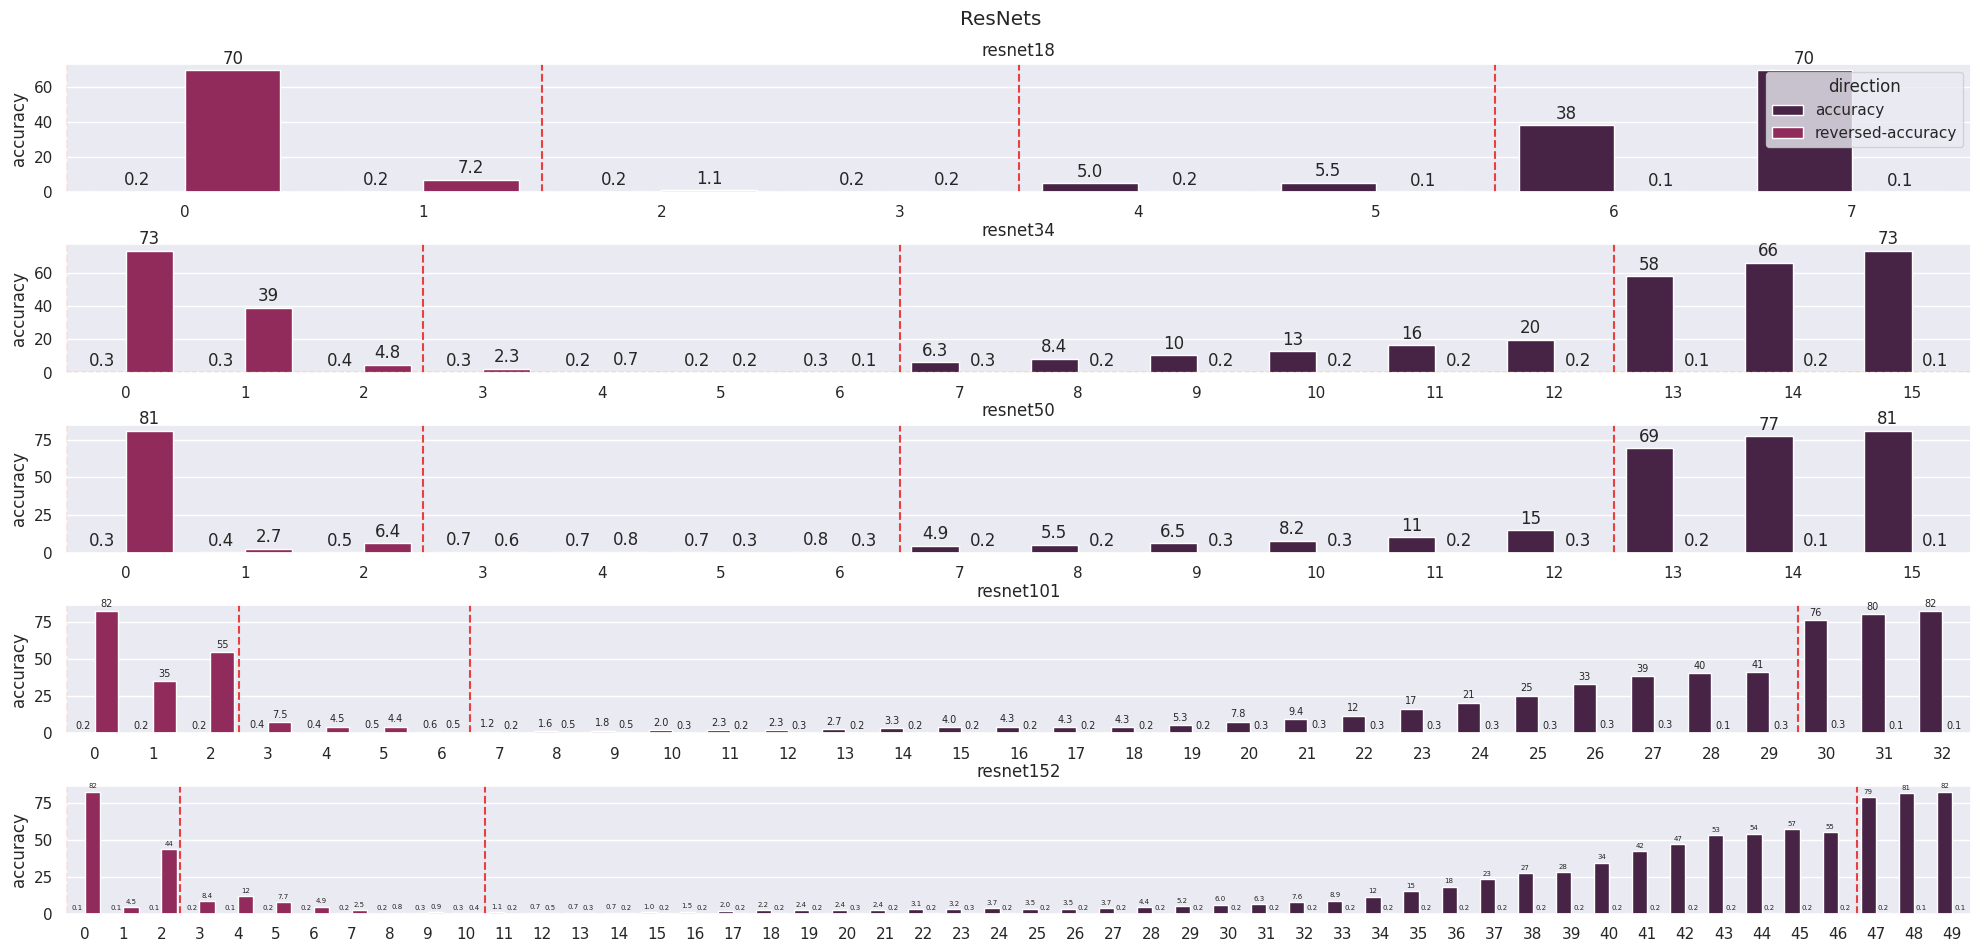

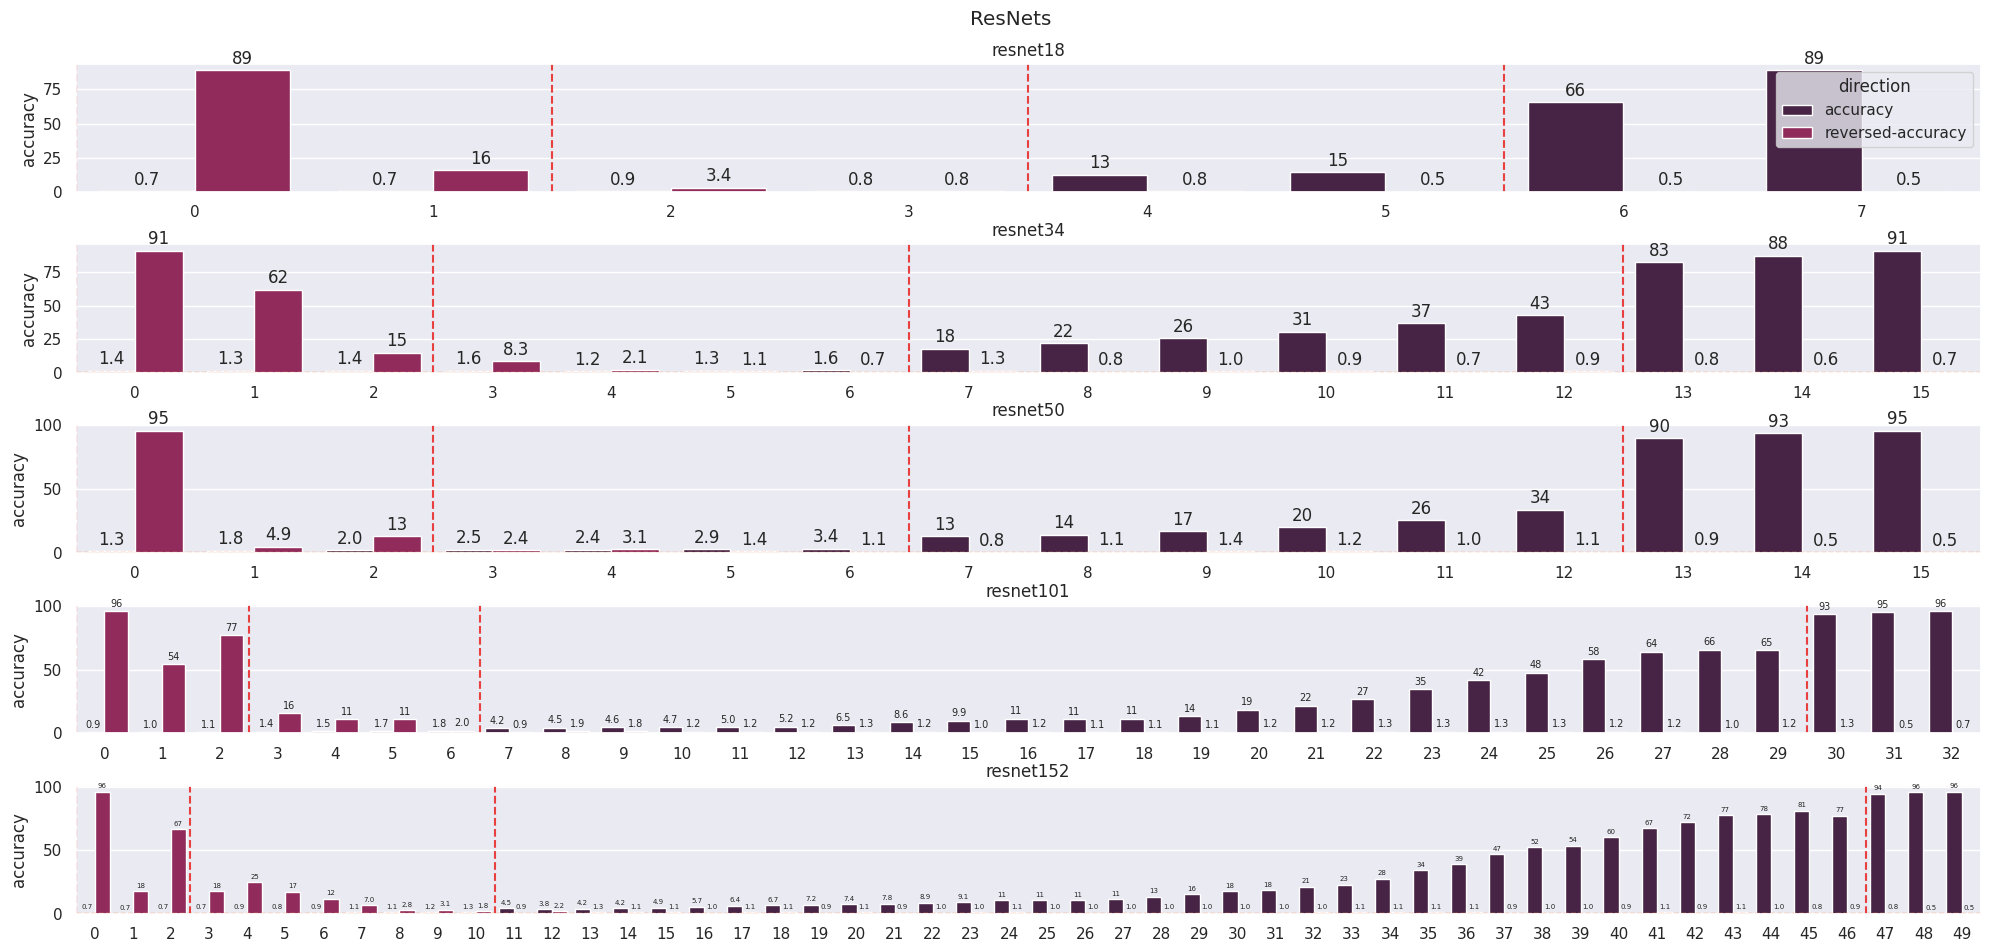

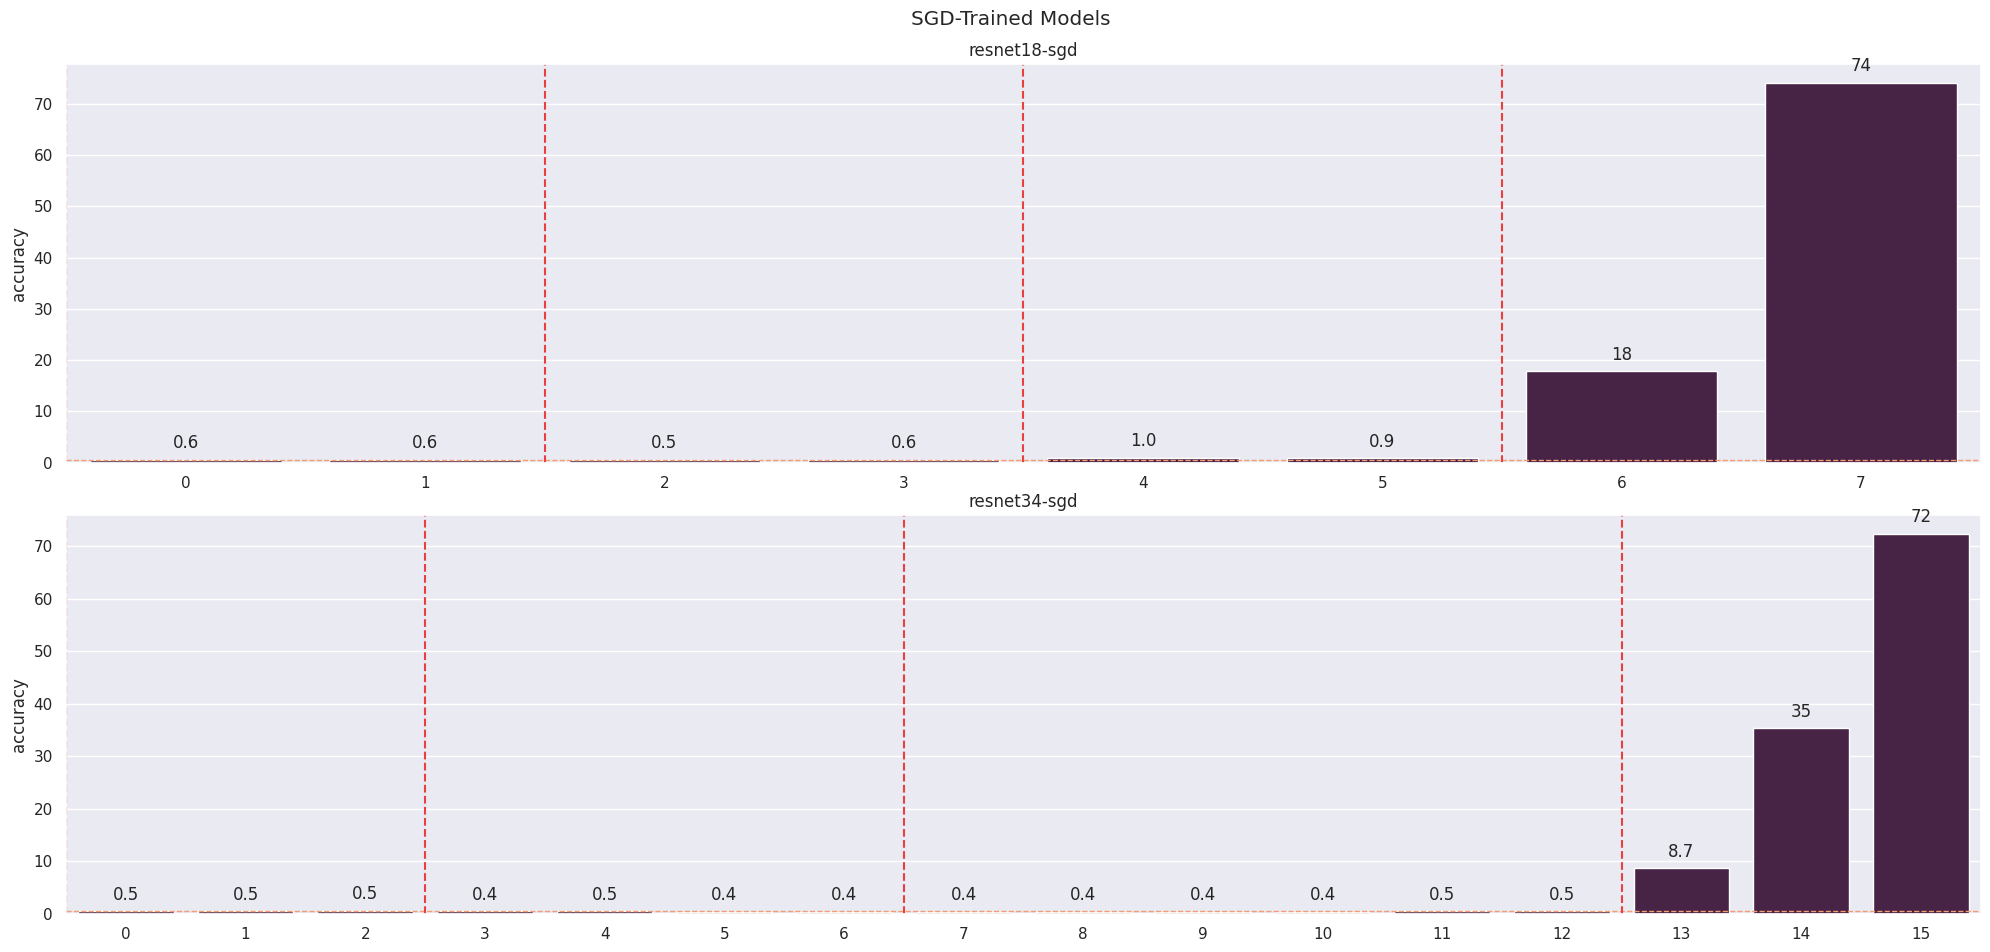

In [18]:
# plot text results
base_df.loc[:, "accuracy"] = base_df["accuracy"]
base_df.loc[:, "reversed-accuracy"] = reverse(base_df["reversed-accuracy"])
plot_accuracy(base_df, title="Small LLMs", num_classes=3)

large_df.loc[:, "accuracy"] = large_df["accuracy"]
large_df.loc[:, "reversed-accuracy"] = reverse(large_df["reversed-accuracy"])
plot_accuracy(large_df, title="Large LLMs", num_classes=3)

# plot image results for top-1 and top-5
resnet_df.loc[:, "accuracy"] = resnet_df["top1"]
resnet_df.loc[:, "reversed-accuracy"] = resnet_df["reversed-top1"]
plot_accuracy(resnet_df, title="ResNets", num_classes=1000)

resnet_df.loc[:, "accuracy"] = resnet_df["top5"]
resnet_df.loc[:, "reversed-accuracy"] = resnet_df["reversed-top5"]
plot_accuracy(resnet_df, title="ResNets", num_classes=200)

# plot results for models trained by sgd
sgd_resnet_df = sgd_df[sgd_df["model"].str.match(r"resnet\d+")]
sgd_resnet_df.loc[:,"accuracy"] = sgd_resnet_df["top5"]
plot_accuracy(sgd_resnet_df, title="SGD-Trained Models", num_classes=200)
plt.gcf().axes[0].get_legend().remove()